# Cluster Analysis Tutorial

This notebook is a continuation of the Preprocess tutorial, and assumes you are working with a SeuratObject that has been pre-processed (i.e. quality controlled to filter cells, normalized, highly variable genes selected, visualization coordinates calculated). In this tutorial, we will cluster our dataset, identify marker genes and annotate our clusters, and look at the expression of individual genes.

This notebook is largely adapted from the Seurat Vignettes [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html) and [Using sctransform in Seurat](https://satijalab.org/seurat/articles/sctransform_vignette.html) by Christoph Hafemeister & Rahul Satija with addtions from Caitlin's preprocess_tutorial.ipynb which is largely adapted from 
an [ipython notebook](https://github.com/theislab/single-cell-tutorial) provided by the Theis Lab as part of their Molecular Systems Biology submission "Current best practices in single‐cell RNA‐seq analysis: a tutorial" ([Luecken and Theis, 2019](https://doi.org/10.15252/msb.20188746)), as well as the basic scanpy [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial. The original vignettes, notebooks and paper are worth checking out to get a more in-depth idea of the steps involved with scRNA-seq analysis (and the "best" ways to do them!). We also heavily utilized Bioconductor's online book [*Orchestrating Single-Cell Analysis with Bioconductor*](https://bioconductor.org/books/release/OSCA/) for some of the conceptual explanations. This is a fantastic resource to take a deeper dive into the various steps of scRNA-seq analysis (and is great if you are doing your scRNA-seq analysis in R!).)

For the first two tutorials - Preprocess and Cluster Analysis - we will be working with a publicly available scRNA-seq dataset that consists of *3k PBMCs from a Healthy Donor*, which is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). 

# Table of Contents

* [1 Setting Up the Coding Environment](#1-Setting-Up-the-Coding-Environment)
* [2 Reading in the Data](#2-Reading-in-the-Data)
* [3 Clustering](#3-Clustering)
* [4 Finding differentially expressed features](#4-Finding-differentially-expressed-features)
* [5 Annotating Clusters](#5-Annotating-Clusters)
* [6 Gene Set Expression Plots](#6-Gene-Set-Expression-Plots)
* [7 Cluster Manipulation](#7-Cluster-Manipulation)
    - [Removing Clusters](#Removing-Clusters)
    - [Merging Clusters](#Merging-Clusters)
    - [Splitting Clusters](#Splitting-Clusters)
* [8 Summary](#8-Summary)
* [Appendix](#Appendix)
    - [Subsetting Data](#Subsetting-Data)
    - [Additional Plotting Tools](#Additional-Plotting-Tools)

# 1 Setting Up the Coding Environment

Just like in our Preprocess tutorial, we need to set up our jupyter notebook and load in all of the python modules, packages, and libraries we need for scRNA-seq analysis. The coding environment for this notebook is the same as what we used for the Preprocess tutorial.

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(ggsci)
library(readxl)
library(tidyr)
#options(future.globals.maxSize = 4000 * 1024^2)  Don't need this for this dataset, but if you have a large dataset you may need this


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
options(repr.plot.width=10, repr.plot.height=7)

Here's a palette of colors that is basically color blind friendly.  This was originally a palette of 15 colors (which is really the limit of a discreet palette that is actually color blind friendly) to which I've added 3 additional colors which may work in a pinch since we are often dealing with more than 15 clusters in a dataset.  Unfortunately, I can no longer find the original source of this palette.

In [3]:
cbpal18 <- c("#68023F","#008169","#EF0096","#00DCB5","#FFCFE2",
           "#003C86","#9400E6","#009FFA","#FF71FD","#7CFFFA",
           "#6A0213","#008607","#F60239","#00E307","#FFDC3D","#ffea8a","#001310","#ffe9f1")

# 2 Reading in the Data

In our Preprocess tutorial we loaded in a built-in dataset provided with the scanpy toolkit (or, if you were following along with your own data, then you read in the data files generated by Cell Ranger). Here, we are going to read in our preprocessed adata object from the Preprocess tutorial (remember, we saved this as an .h5ad file at the end of the notebook). Reading in .h5ad objects is super simple in scanpy:

In [4]:
pbmc <- readRDS(file = "output/pbmc.RDS")

In [5]:
pbmc
head(pbmc@meta.data)

An object of class Seurat 
26233 features across 2638 samples within 2 assays 
Active assay: SCT (12519 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

orig.ident nCount_RNA nFeature_RNA percent.mt nCount_SCT
AAACATACAACCAC-1 pbmc3k     2419        779         3.0177759  2305      
AAACATTGAGCTAC-1 pbmc3k     4903       1352         3.7935958  2665      
AAACATTGATCAGC-1 pbmc3k     3147       1129         0.8897363  2498      
AAACCGTGCTTCCG-1 pbmc3k     2639        960         1.7430845  2368      
AAACCGTGTATGCG-1 pbmc3k      980        521         1.2244898  1983      
AAACGCACTGGTAC-1 pbmc3k     2163        781         1.6643551  2172      
                 nFeature_SCT
AAACATACAACCAC-1  779        
AAACATTGAGCTAC-1 1123        
AAACATTGATCAGC-1 1125        
AAACCGTGCTTCCG-1  958        
AAACCGTGTATGCG-1  562        
AAACGCACTGGTAC-1  781

# 3 Clustering

Seurat v3 applies a graph-based clustering approach, building upon initial strategies in ([Macosko et al](http://www.cell.com/abstract/S0092-8674(15)00549-8)). Importantly, the distance metric which drives the clustering analysis (based on previously identified PCs) remains the same. However, Seurat's approach to partitioning the cellular distance matrix into clusters has dramatically improved. This approach was heavily inspired by recent manuscripts which applied graph-based clustering approaches to scRNA-seq data [SNN-Cliq, Xu and Su, Bioinformatics, 2015](http://bioinformatics.oxfordjournals.org/content/early/2015/02/10/bioinformatics.btv088.abstract) and CyTOF data [PhenoGraph, Levine et al., Cell, 2015](http://www.ncbi.nlm.nih.gov/pubmed/26095251). Briefly, these methods embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar feature expression patterns, and then attempt to partition this graph into highly interconnected ‘quasi-cliques’ or ‘communities’.

We first construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). This step is performed using the `FindNeighbors()` function, and takes as input the previously defined dimensionality of the dataset (first 30 PCs).

To cluster the cells, we next apply modularity optimization techniques such as the Louvain algorithm (default) or SLM [SLM, Blondel et al., Journal of Statistical Mechanics](http://dx.doi.org/10.1088/1742-5468/2008/10/P10008), to iteratively group cells together, with the goal of optimizing the standard modularity function. The `FindClusters()` function implements this procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. The Seurat developers find that setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters can be found using the `Idents()` function.

In [6]:
pbmc <- FindNeighbors(pbmc, dims = 1:30)
pbmc <- FindClusters(pbmc, resolution = 0.5)
pbmc <- FindClusters(pbmc, resolution = 0.7)
pbmc <- FindClusters(pbmc, resolution = 0.8)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 112602

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8814
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 112602

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8455
Number of communities: 11
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 112602

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8326
Number of communities: 13
Elapsed time: 0 seconds


You will see that we've added 5 columns to the meta.data table: `SCT_snn_res0.5`, `SCT_snn_res.0.7`, `SCT_snn_res.0.8`, and `seurat_clusters`.  The first 3 columns contain the cluster assignment for each cell at each of the given resolutions.  The `seurat_clusters` contains the latest `FindClusters()` results. Note that `seurat_clusters` will be overwritten everytime `FindClusters()` is run.  To change the current identity use `Idents()`.

In [7]:
head(pbmc@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt nCount_SCT
AAACATACAACCAC-1 pbmc3k     2419        779         3.0177759  2305      
AAACATTGAGCTAC-1 pbmc3k     4903       1352         3.7935958  2665      
AAACATTGATCAGC-1 pbmc3k     3147       1129         0.8897363  2498      
AAACCGTGCTTCCG-1 pbmc3k     2639        960         1.7430845  2368      
AAACCGTGTATGCG-1 pbmc3k      980        521         1.2244898  1983      
AAACGCACTGGTAC-1 pbmc3k     2163        781         1.6643551  2172      
                 nFeature_SCT SCT_snn_res.0.5 seurat_clusters SCT_snn_res.0.7
AAACATACAACCAC-1  779         2               4               4              
AAACATTGAGCTAC-1 1123         3               2               3              
AAACATTGATCAGC-1 1125         0               1               2              
AAACCGTGCTTCCG-1  958         1               5               1              
AAACCGTGTATGCG-1  562         4               6               5              
AAACGCACTGGTAC-1  781         0               1               2              
                 SCT_snn_res.0.8
AAACATACAACCAC-1 4              
AAACATTGAGCTAC-1 2              
AAACATTGATCAGC-1 1              
AAACCGTGCTTCCG-1 5              
AAACCGTGTATGCG-1 6              
AAACGCACTGGTAC-1 1

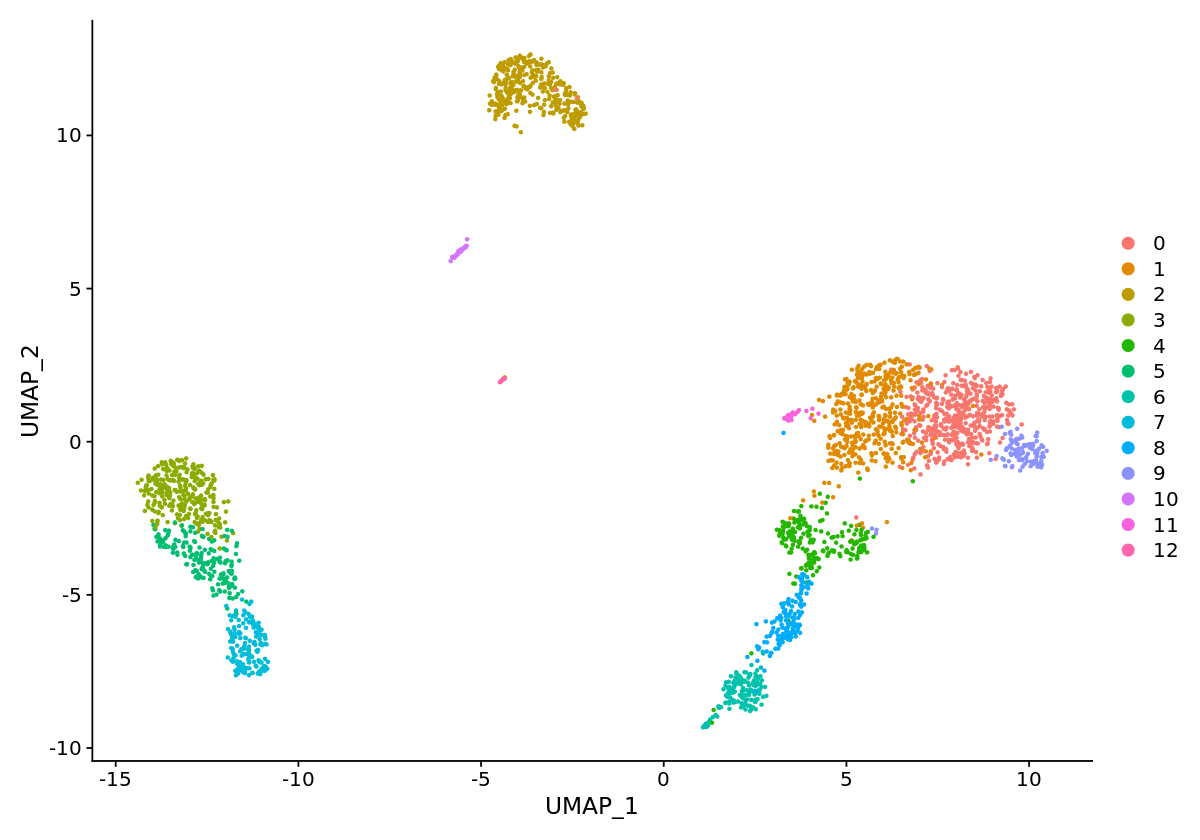

In [8]:
DimPlot(pbmc)  ## Note the pbmc idents = "SCT_snn_res.0.8" since that was last
## FindClusters run and no call of Idents(pbmc) has been used to change the identity.

Again, I prefer other colors to more easily distinguish clusters. Note, using "group.by" adds a title to the plot. 

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



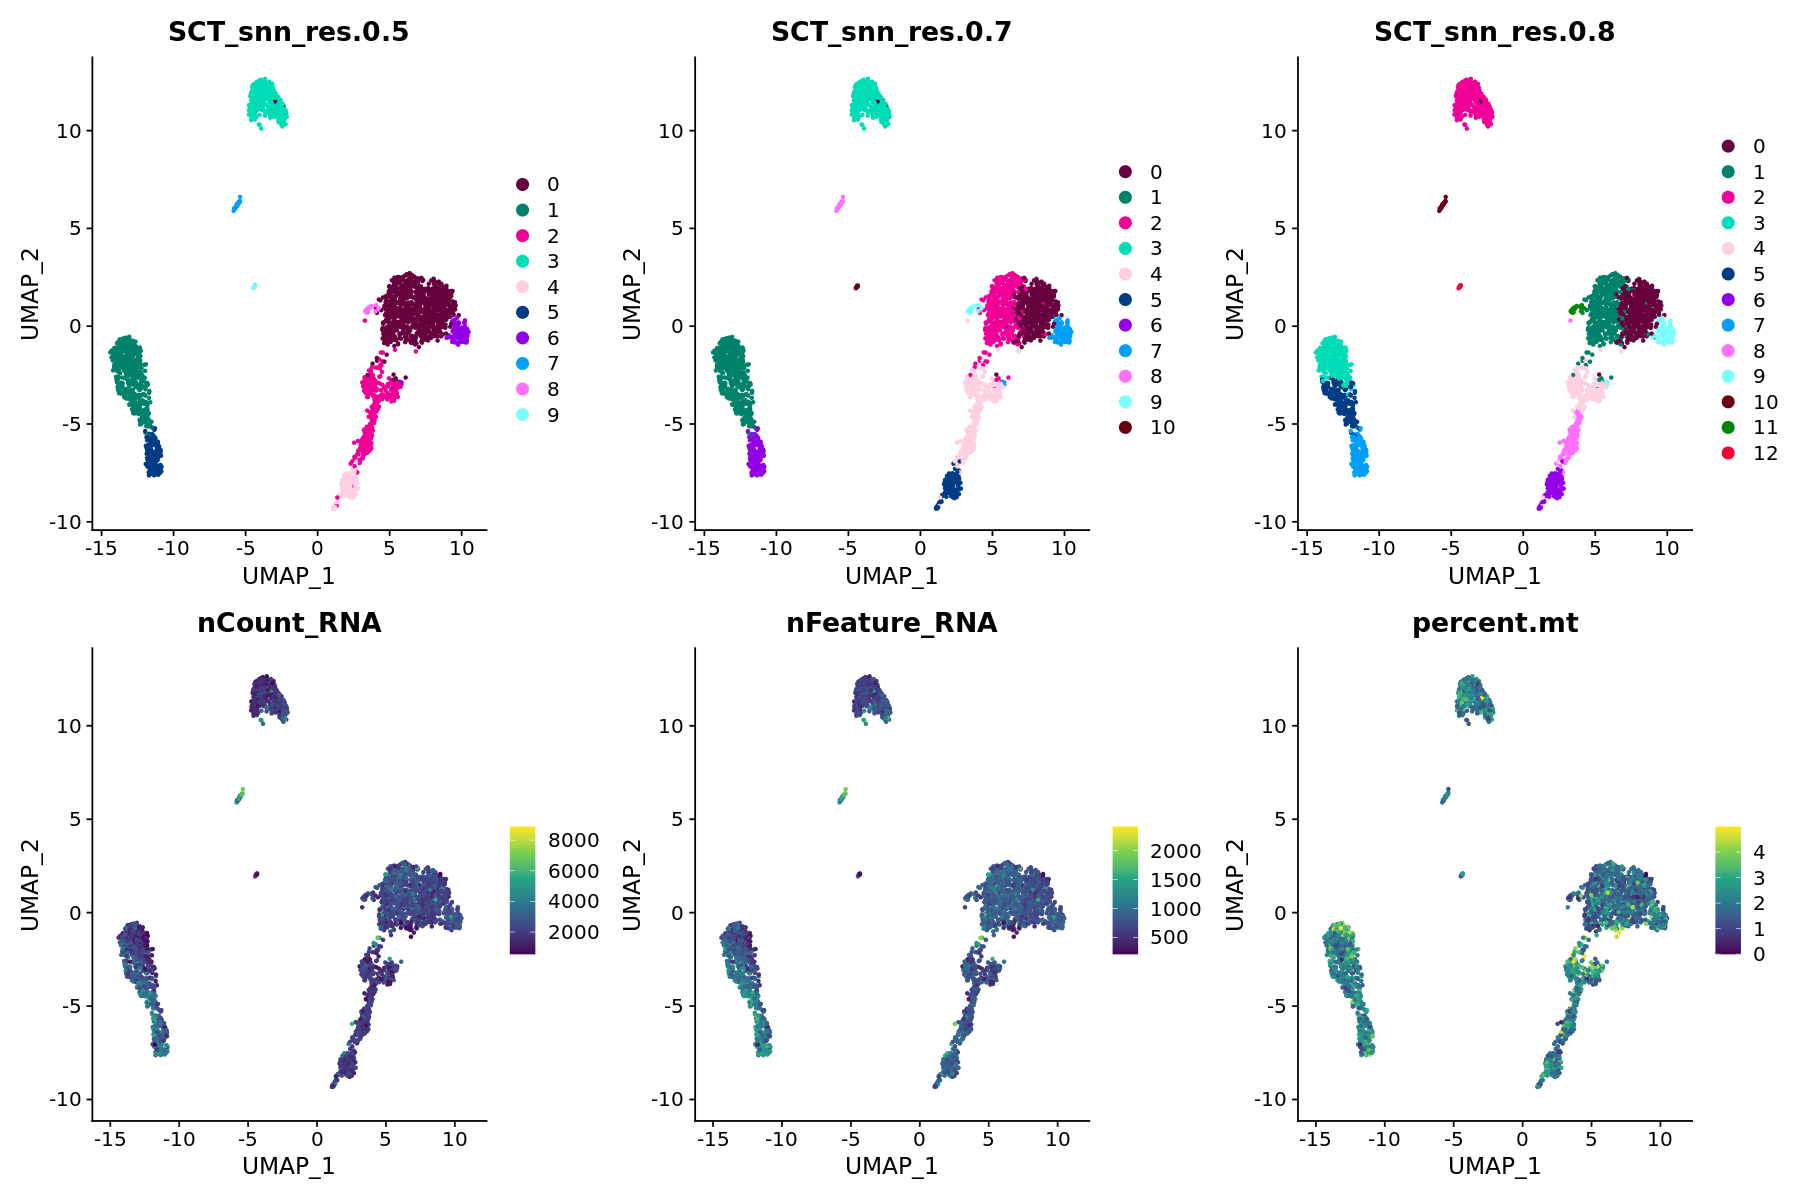

In [9]:
options(repr.plot.width=15, repr.plot.height=10)
p1 <- DimPlot(pbmc, group.by = "SCT_snn_res.0.5", cols = cbpal18)
p2 <- DimPlot(pbmc, group.by = "SCT_snn_res.0.7", cols = cbpal18)
p3 <- DimPlot(pbmc, group.by = "SCT_snn_res.0.8", cols = cbpal18)
p4 <- FeaturePlot(pbmc, features="nCount_RNA") + scale_color_viridis_c()
p5 <- FeaturePlot(pbmc, features="nFeature_RNA") + scale_color_viridis_c()
p6 <- FeaturePlot(pbmc, features="percent.mt") + scale_color_viridis_c()
p1 + p2 + p3 + p4 + p5 + p6 + plot_layout(ncol=3)

# 4 Finding differentially expressed features

Seurat can help you find markers that define clusters via differential expression. By default, it identifies positive and negative markers of a single cluster (specified in ident.1), compared to all other cells. `FindAllMarkers()` automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The min.pct argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. As another option to speed up these computations, max.cells.per.ident can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significant and the most highly differentially expressed features will likely still rise to the top.

Before running `FindMarkers()` I recommend always setting the `Idents()` of the SeuratObject and then making a quick plot to double check the clusters you are finding markers for are actually the ones you are using.  We'll use the "SCT_snn_res.0.5" markers.

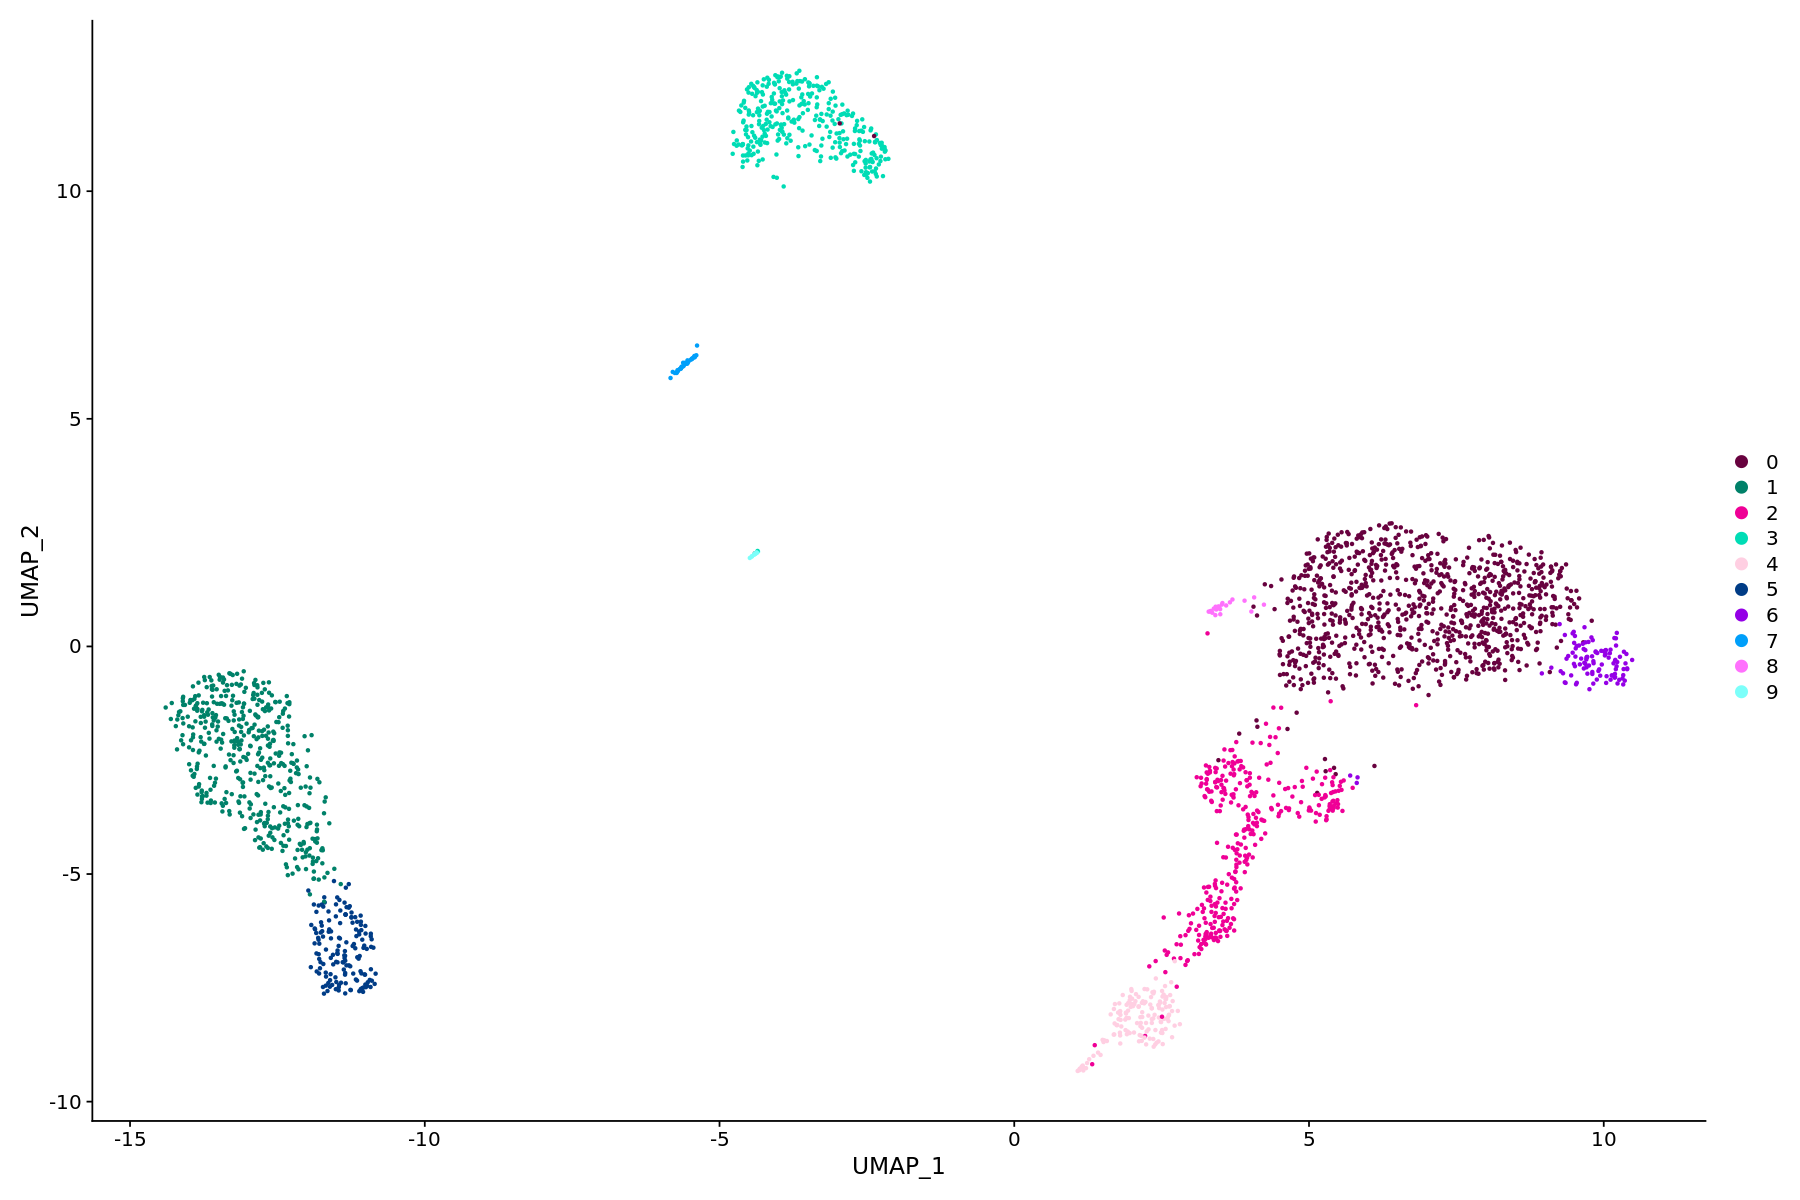

In [10]:
Idents(pbmc) <- "SCT_snn_res.0.5"
DimPlot(pbmc, cols = cbpal18)

Here are some examples of various ways to find differentially expressed genes in the clusters.

In [11]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
CCL5 1.301247e-260 2.804679   0.980 0.195 1.629032e-256
GZMK 2.541972e-181 1.590102   0.547 0.044 3.182295e-177
NKG7 6.732518e-179 1.807314   0.889 0.189 8.428439e-175
GZMA 1.389673e-160 1.193953   0.726 0.112 1.739731e-156
CST7 5.298951e-159 1.198385   0.712 0.110 6.633757e-155

In [12]:
# find all markers distinguishing cluster 6 from clusters 0 and 8
cluster5.markers <- FindMarkers(pbmc, ident.1 = 6, ident.2 = c(0, 8), min.pct = 0.25)
head(cluster5.markers, n = 5)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
CD8B          8.352260e-148 1.7055653  0.971 0.061 1.045619e-143
CD8A           2.783180e-84 0.9126303  0.606 0.037  3.484263e-80
RP11-291B21.2  1.142720e-82 0.7981356  0.500 0.018  1.430571e-78
S100B          2.296563e-49 0.7542397  0.288 0.009  2.875067e-45
CARS           1.675235e-26 0.3788807  0.346 0.051  2.097227e-22

In [13]:
# find markers for every cluster compared to all remaining cells, 
# report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# using dplyr find the top 2 genes in the pbmc.markers for each cluster sorted by avg_log2FC
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n=2, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene         
1  9.752598e-199 1.0353416  0.946 0.499 1.220928e-194 0       LDHB         
2  1.742996e-135 1.1207985  0.951 0.556 2.182056e-131 0       LTB          
3   0.000000e+00 4.4051595  0.992 0.208  0.000000e+00 1       S100A9       
4  2.334374e-271 3.9859216  1.000 0.530 2.922403e-267 1       LYZ          
5  1.301247e-260 2.8046792  0.980 0.195 1.629032e-256 2       CCL5         
6  6.732518e-179 1.8073143  0.889 0.189 8.428439e-175 2       NKG7         
7   0.000000e+00 2.4188939  0.931 0.037  0.000000e+00 3       CD79A        
8  7.567310e-187 2.6089680  1.000 0.839 9.473515e-183 3       CD74         
9  1.766599e-205 4.2110403  0.974 0.120 2.211605e-201 4       GNLY         
10 2.335328e-142 3.4645639  1.000 0.238 2.923597e-138 4       NKG7         
11 4.328015e-180 2.3800963  0.974 0.135 5.418242e-176 5       FCGR3A       
12 2.160945e-124 2.6344909  1.000 0.311 2.705286e-120 5       LST1         
13 1.514748e-165 1.5852425  0.971 0.091 1.896313e-161 6       CD8B         
14 3.557501e-144 0.7988493  0.500 0.018 4.453635e-140 6       RP11-291B21.2
15 2.746506e-233 2.4840932  0.794 0.010 3.438351e-229 7       FCER1A       
16  1.133370e-23 2.6044149  1.000 0.513  1.418866e-19 7       HLA-DPB1     
17  1.386888e-16 2.4928541  1.000 0.426  1.736245e-12 8       ISG15        
18  2.054229e-16 2.1829731  1.000 0.381  2.571690e-12 8       IFI6         
19 1.314783e-171 4.6910375  1.000 0.011 1.645977e-167 9       PF4          
20  9.140061e-95 6.0355069  1.000 0.024  1.144244e-90 9       PPBP

Here we use `dplyr` functions `group_by()` and `top_n()` to get the top 10 genes for each cluster sorted by p_val in accending order (n=-10).  We could then use the Seurat function `DotPlot()` to make a plot of each, but putting this in a for loop makes for much less typing. We loop over each cluster in the current identity of pbmc (levels(pbmc)) and add the dotplot to the list called plotlist.  `RotatedAxis()` is a Seurat function which rotates the names of the x-axis text and `ggtitle()` is a ggplot2 function for adding a title to ggplot. The `patchwork` function `wrap_plots()` prints them all together.

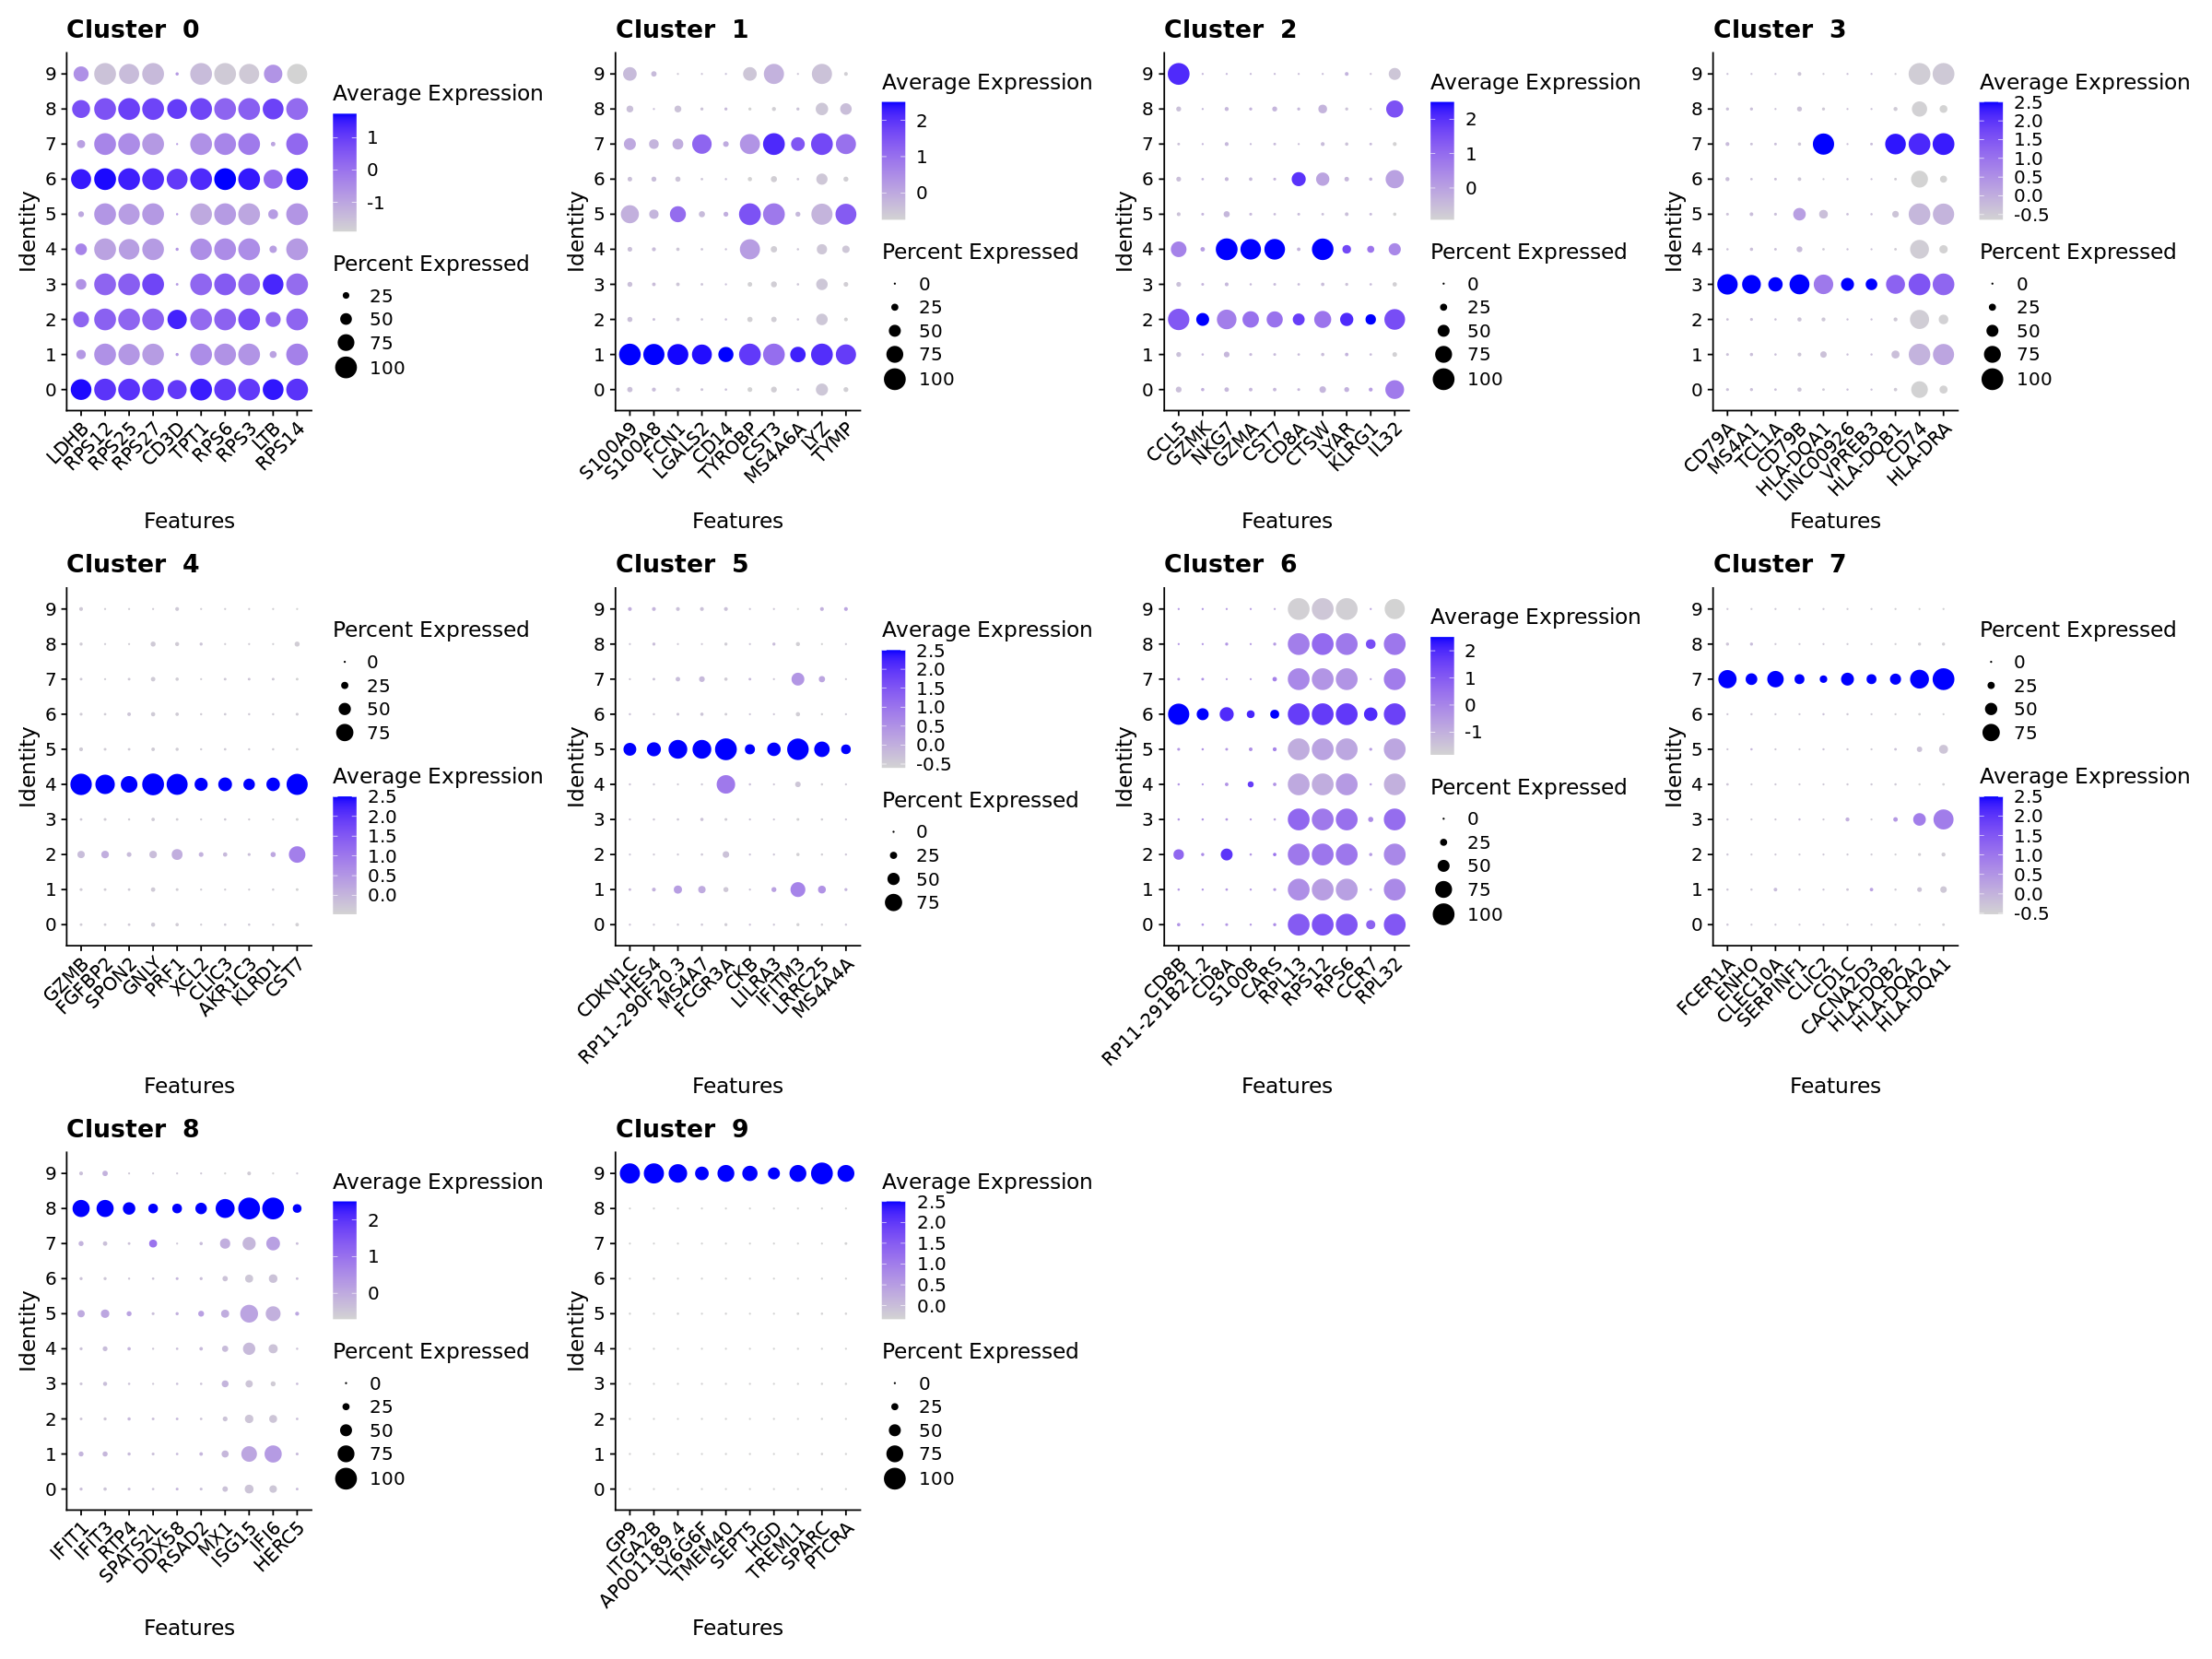

In [14]:
options(repr.plot.width=20, repr.plot.height=15)
top10 <- pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n=-10, wt = p_val)
plotlist <- list()
for(cluster in levels(pbmc)){
    plotlist[[cluster]] <- DotPlot(pbmc, features=top10$gene[top10$cluster == cluster]) + 
          RotatedAxis() + ggtitle(paste("Cluster ",cluster))
}
wrap_plots(plotlist)

# 5 Annotating Clusters

Here is a list of known pbmc marker genes:
* CD4 T Cells: naive=IL7R, CCR7; memory=IL7R,S100A4
* CD8 T Cells: naive=CD8A, memory=GZMK
* Classic Monocytes=CD14, LYZ
* FCGR3A+ Monocytes=FCGR3A, MS4A7
* B Cells=MS4A1, CD19, CD27
* NK Cells=GNLY, NKG7
* Dendritic Cells=FCER1A, CST3
* Megakaryocytes=PPBP

We can make lists of these genes and plot the expression of these marker genes in our pbmc cells in a variety of ways: `FeaturePlot()` which gives a UMAP colored by gene expression, `VlnPlot()` which gives a violin plot of gene expression for each Identity, and `DotPlot()` which gives a dot plot where the size of each dot corresponds to the percentage of cells in a give Idendity which express the gene and the color corresponds to the level of gene expression.

In [15]:
CD4.naive.markers <- c("IL7R","CCR7")
CD4.memory.markers <- c("IL7R","S100A4")
CD8.markers <- c("CD8A","GZMK")
NK.markers <- c("GNLY","NKG7")
Classic.Monocyte.markers <- c("CD14","LYZ")
FCGR3Apos.Monocyte.markers <- c("FCGR3A","MS4A7")
Bcell.markers <- c("MS4A1","CD19","CD27")
Dendritic.markers <- c("FCER1A","CST3")
Megakarocyte.markers <- c("PPBP")

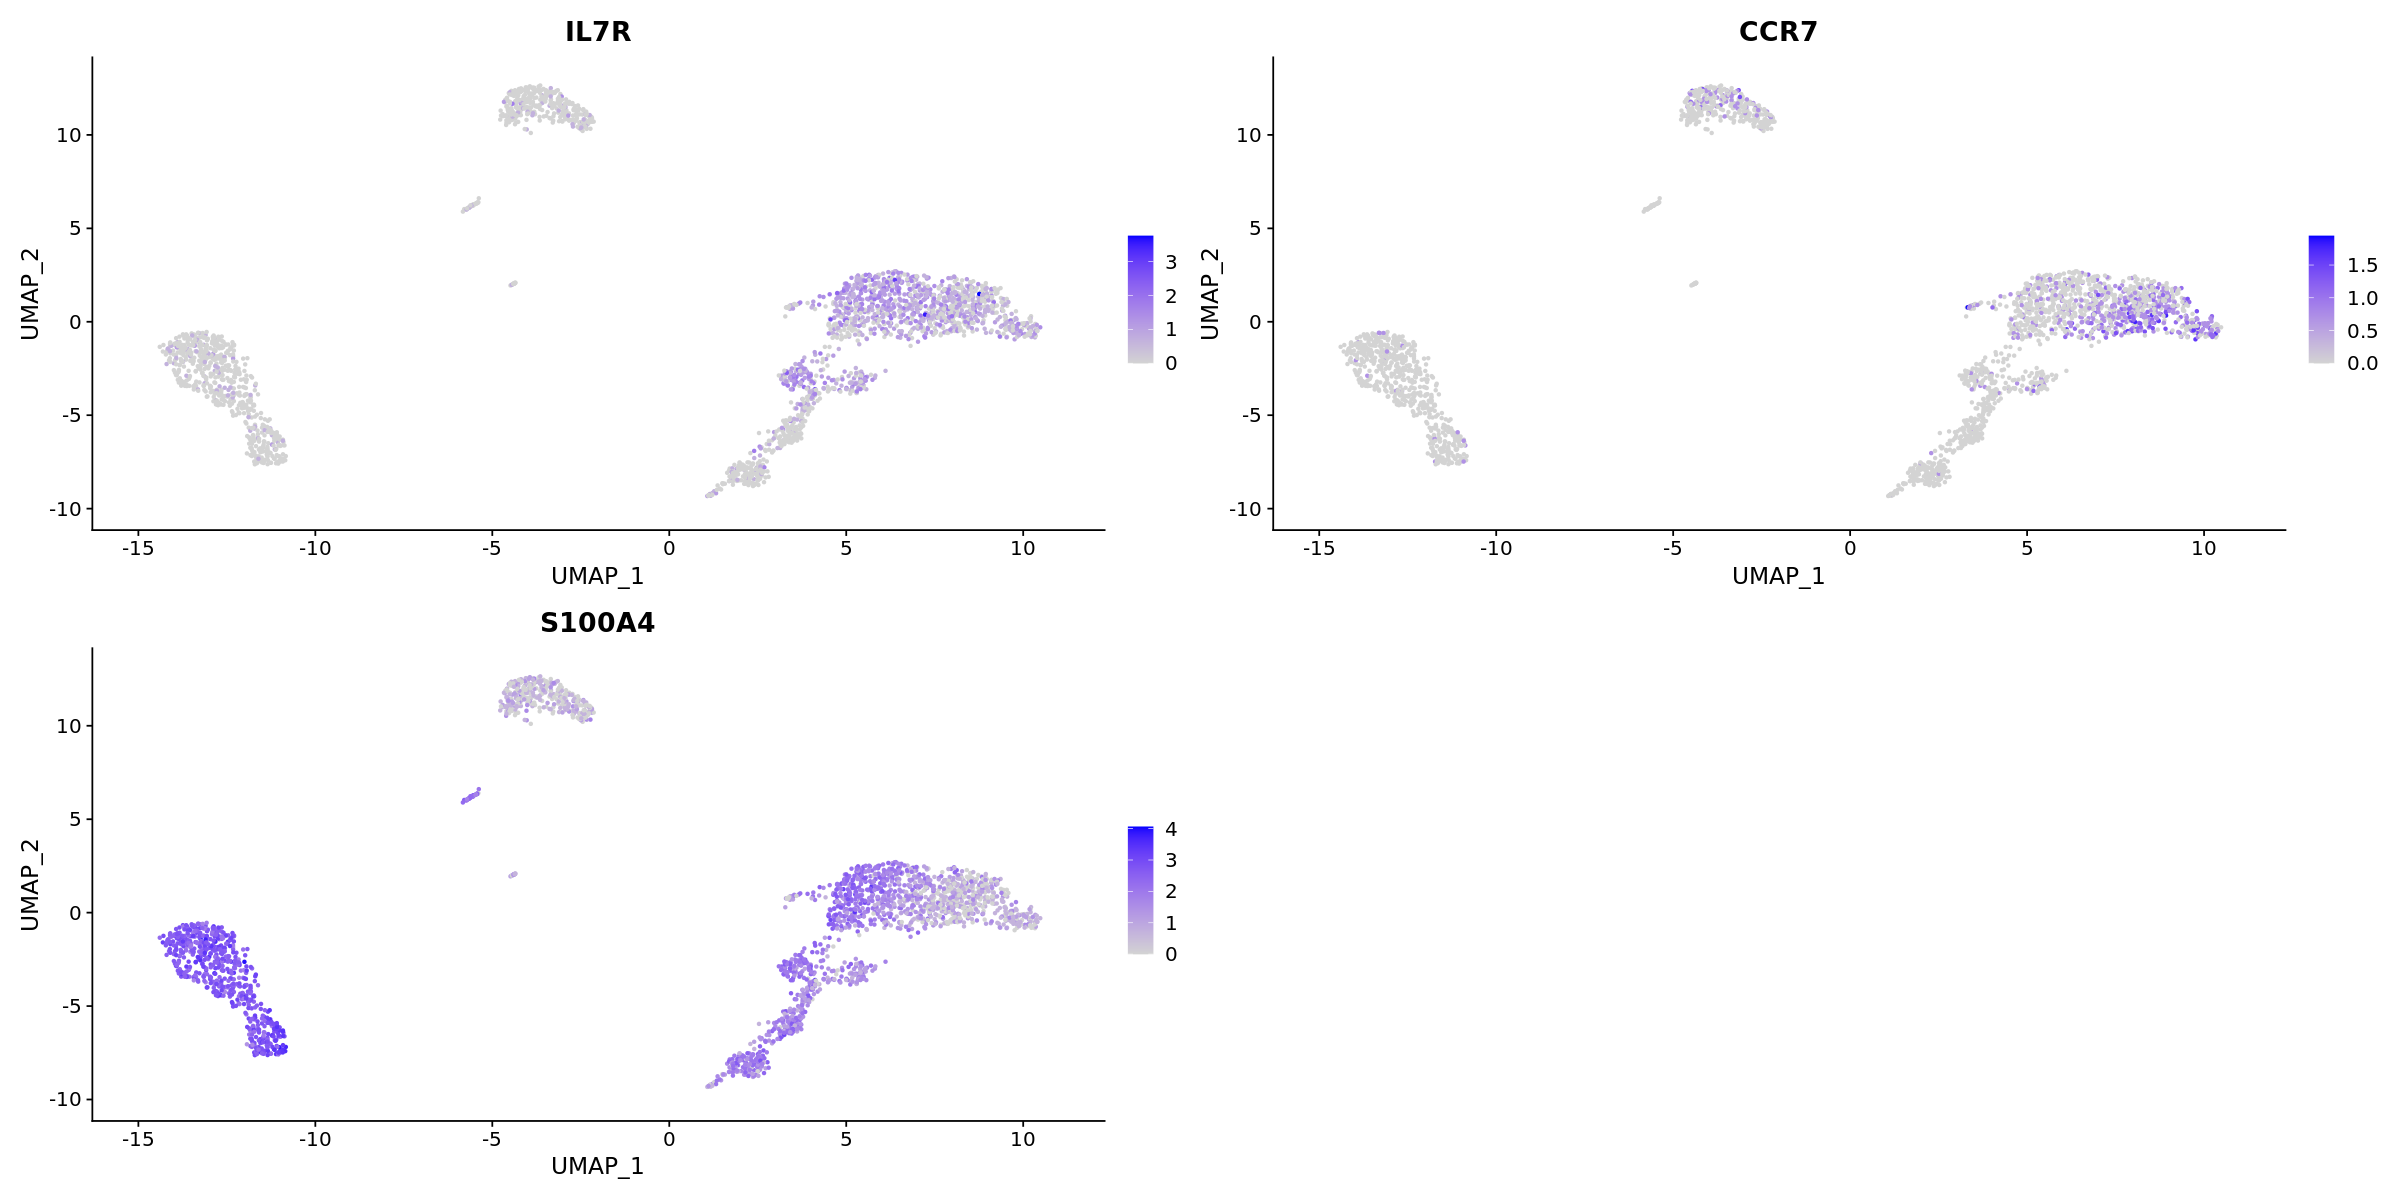

In [16]:
options(repr.plot.width=20, repr.plot.height=10)
FeaturePlot(pbmc, features = c("IL7R","CCR7","S100A4"))

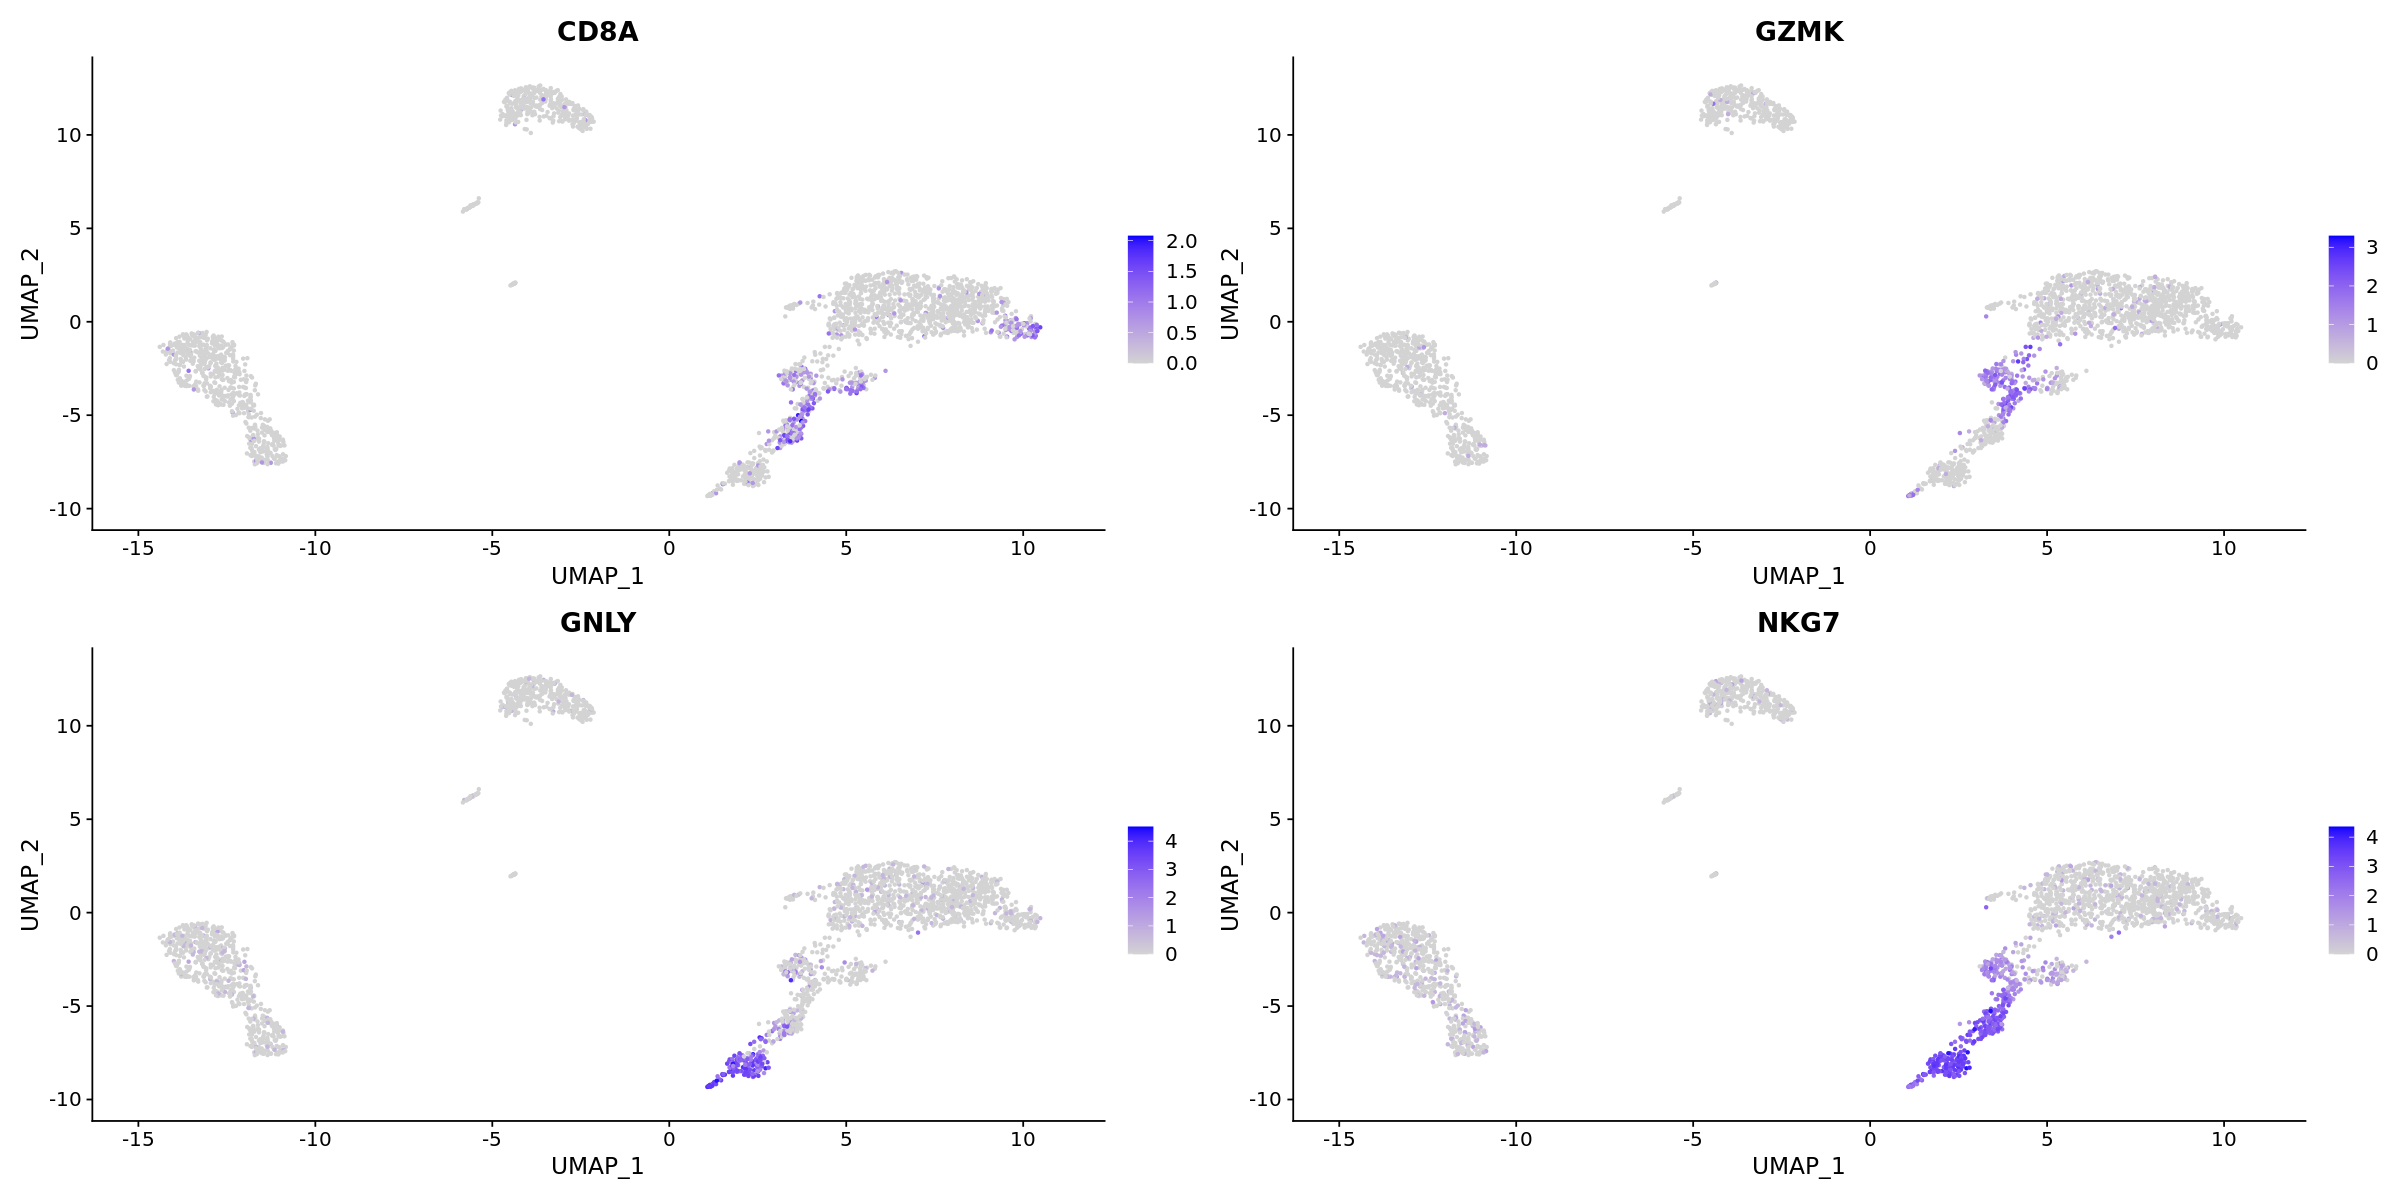

In [17]:
FeaturePlot(pbmc, features = c(CD8.markers,NK.markers))

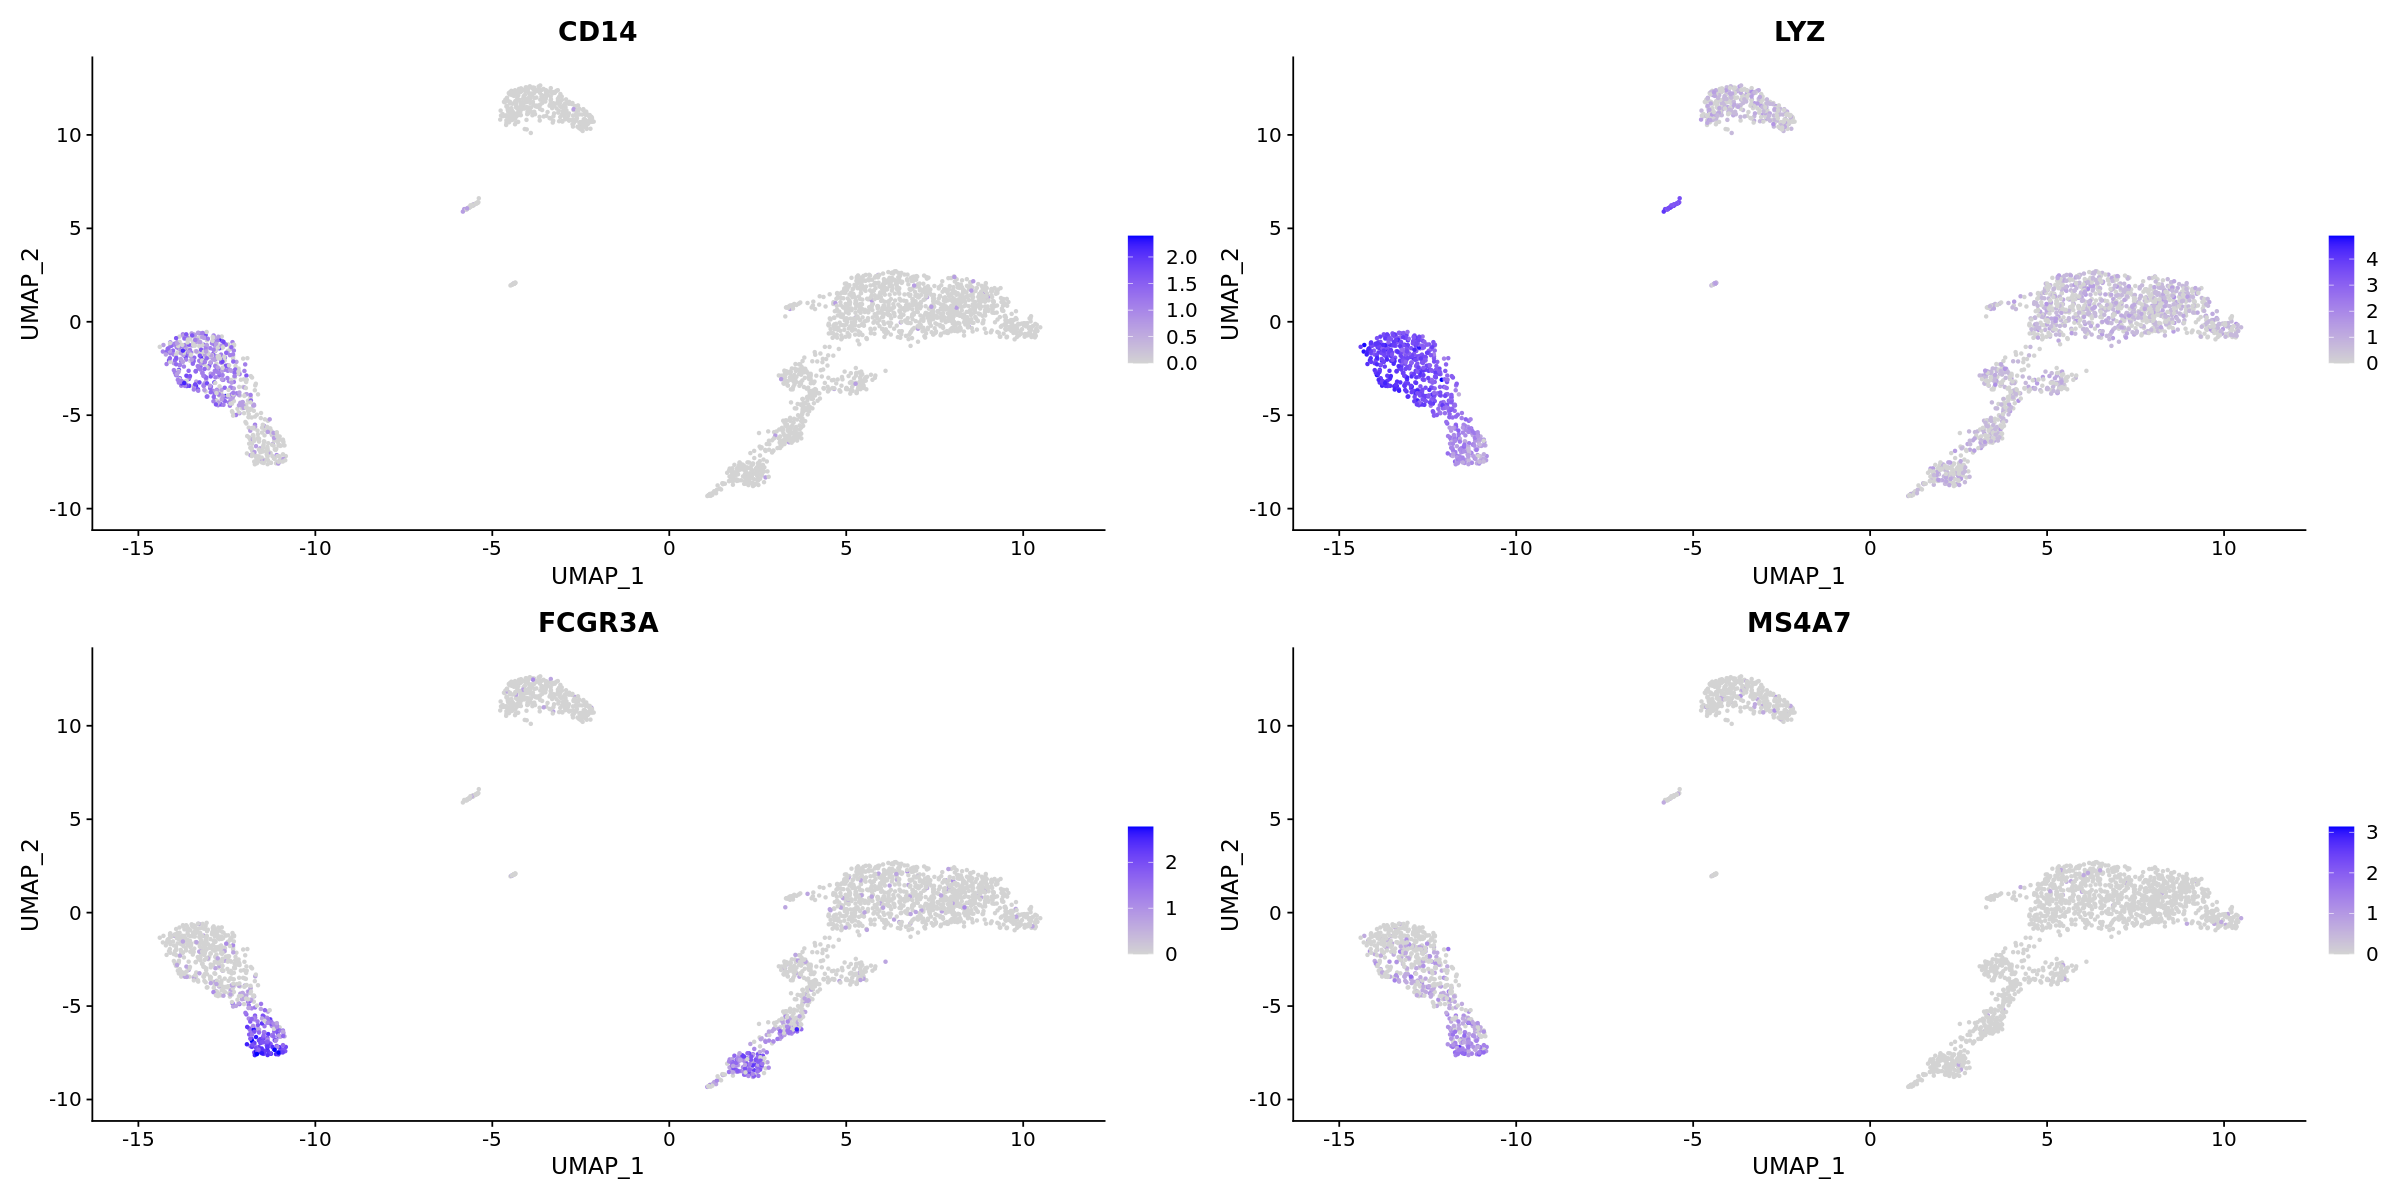

In [18]:
FeaturePlot(pbmc, features = c(Classic.Monocyte.markers,FCGR3Apos.Monocyte.markers))

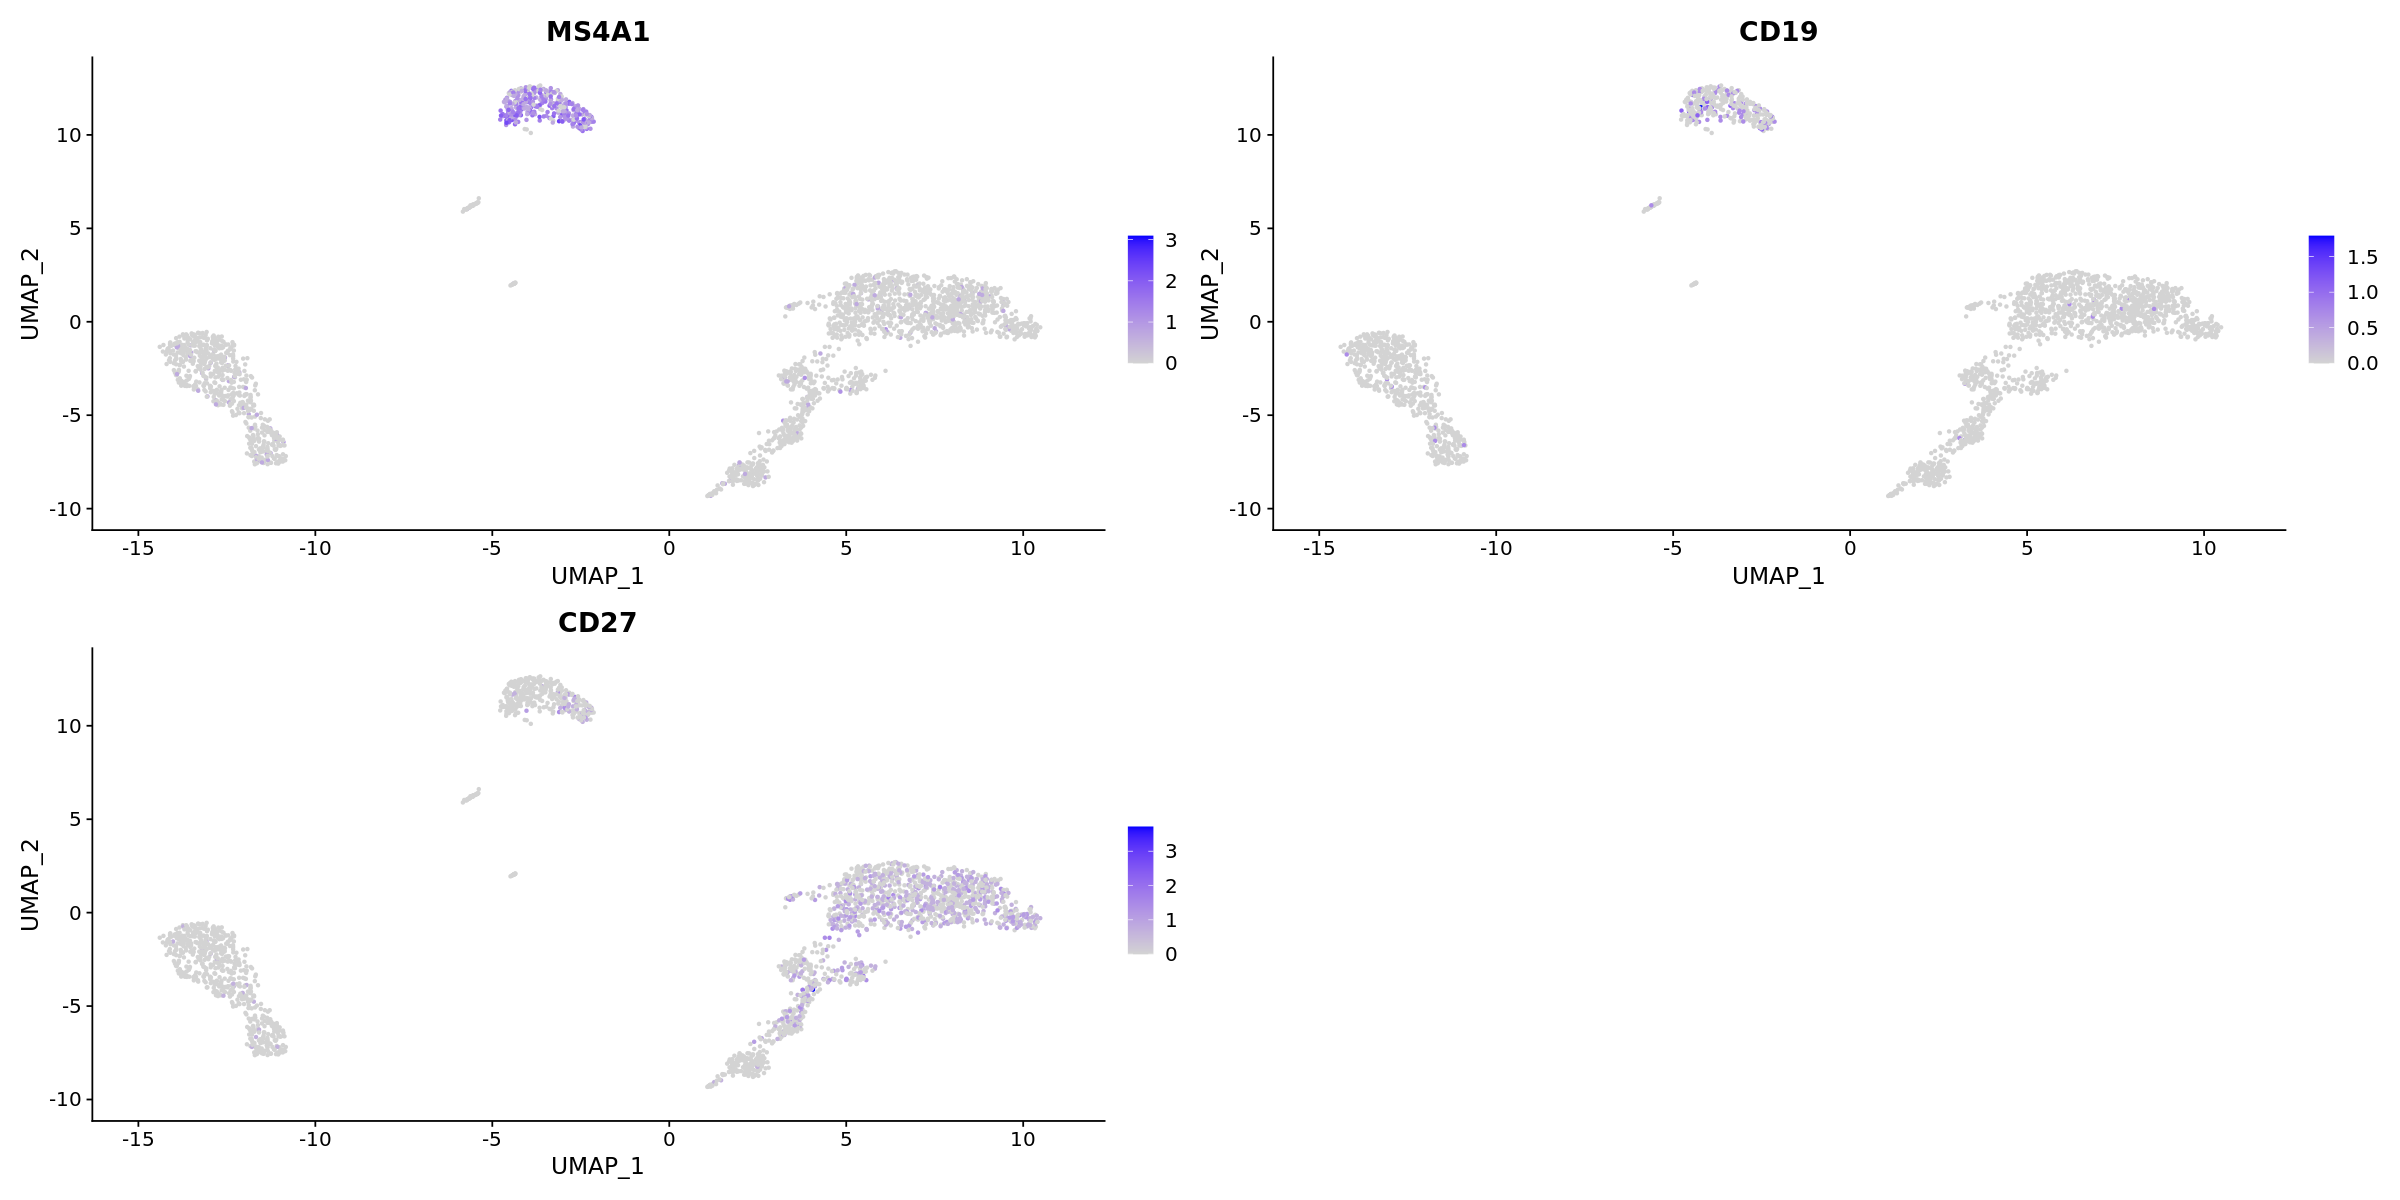

In [19]:
FeaturePlot(pbmc, features = Bcell.markers)

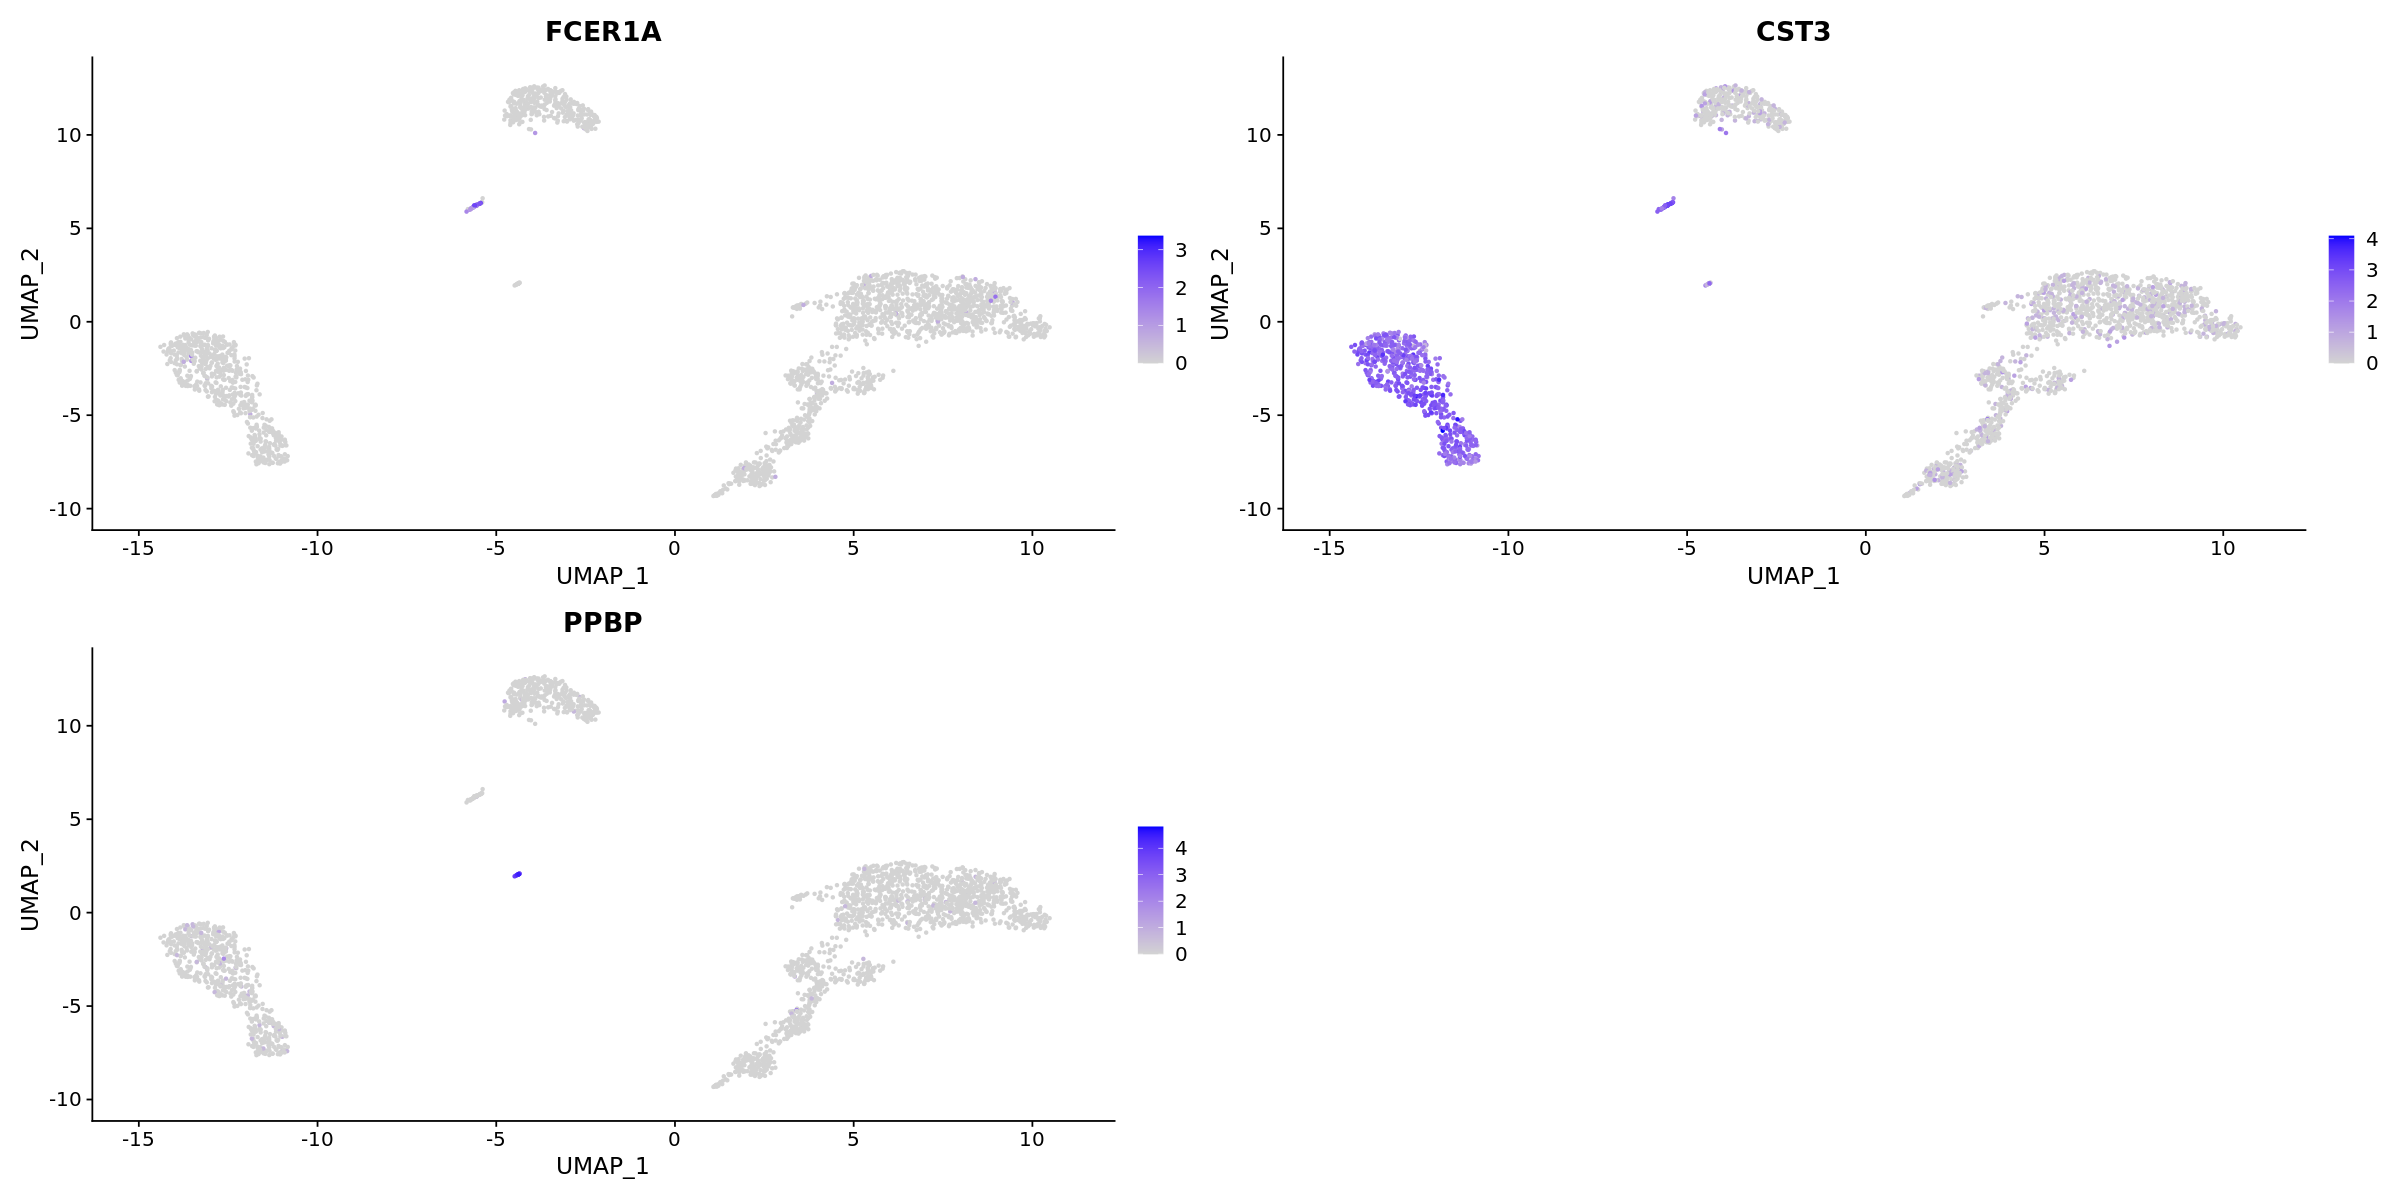

In [20]:
FeaturePlot(pbmc, features = c(Dendritic.markers,Megakarocyte.markers))

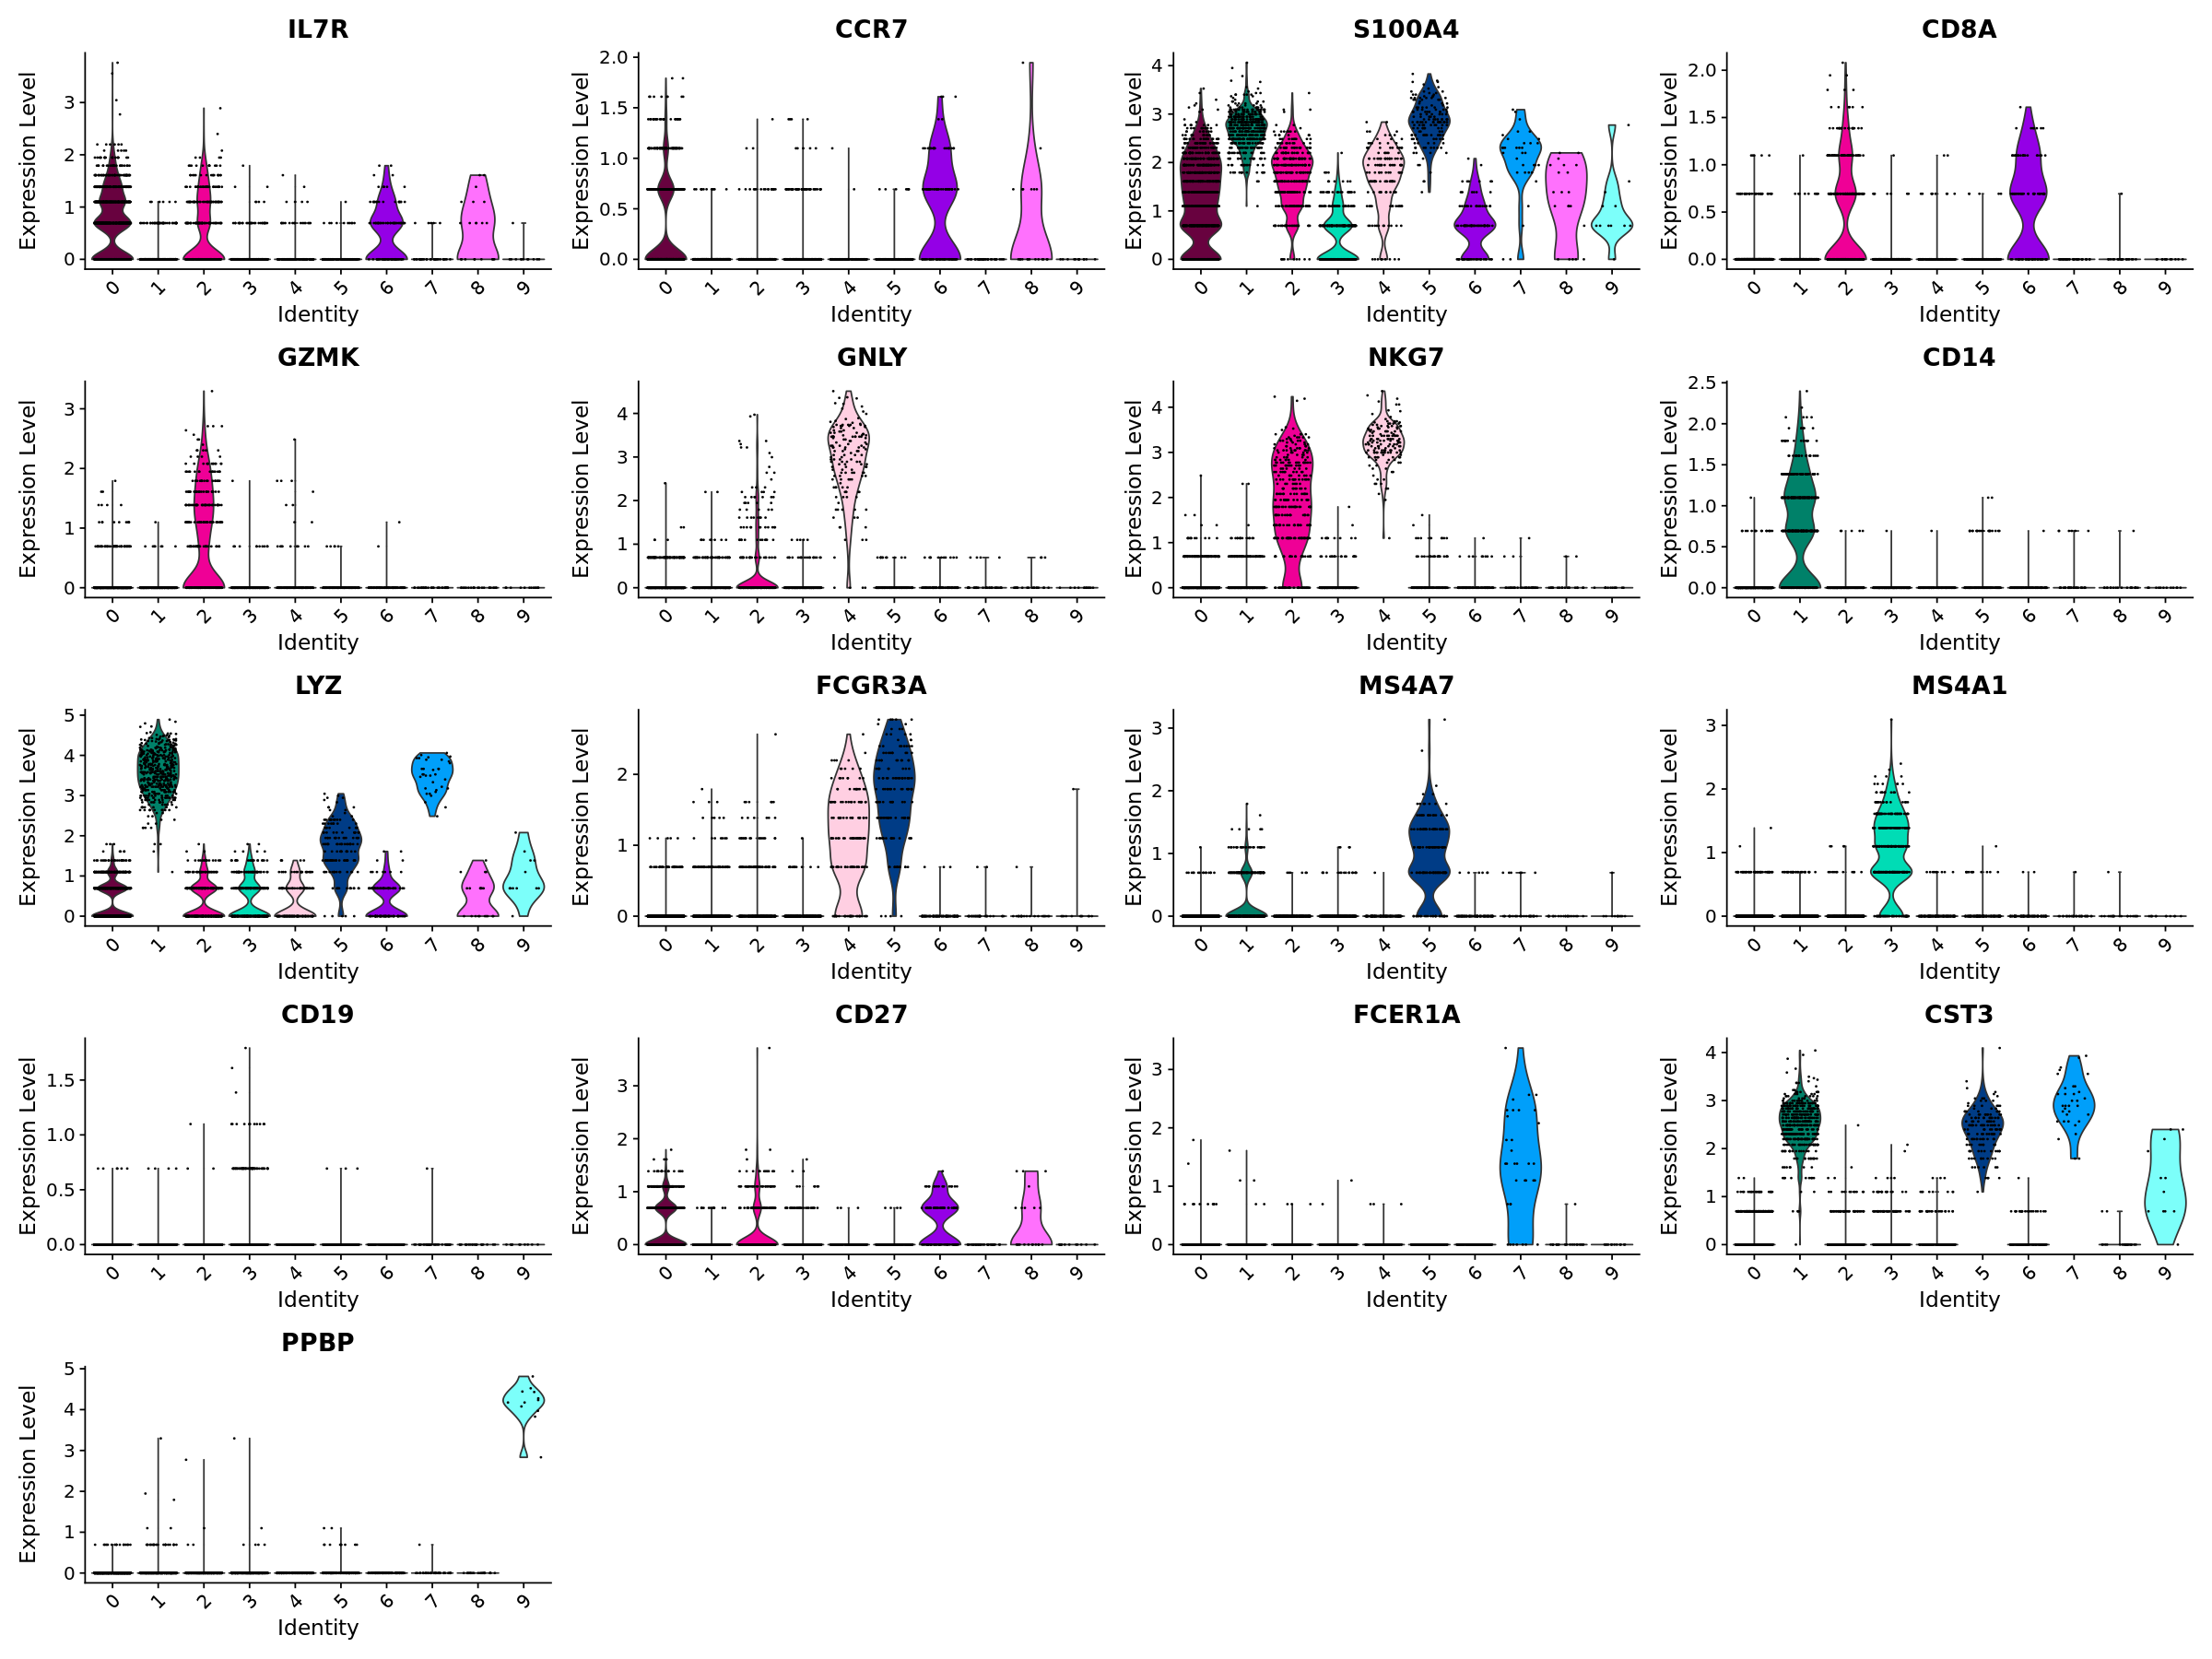

In [21]:
options(repr.plot.width=20, repr.plot.height=15)
VlnPlot(pbmc, features = unique(c(CD4.naive.markers,CD4.memory.markers,CD8.markers
                                  ,NK.markers,Classic.Monocyte.markers,
                                  FCGR3Apos.Monocyte.markers,Bcell.markers,
                                  Dendritic.markers,Megakarocyte.markers)), cols = cbpal18)

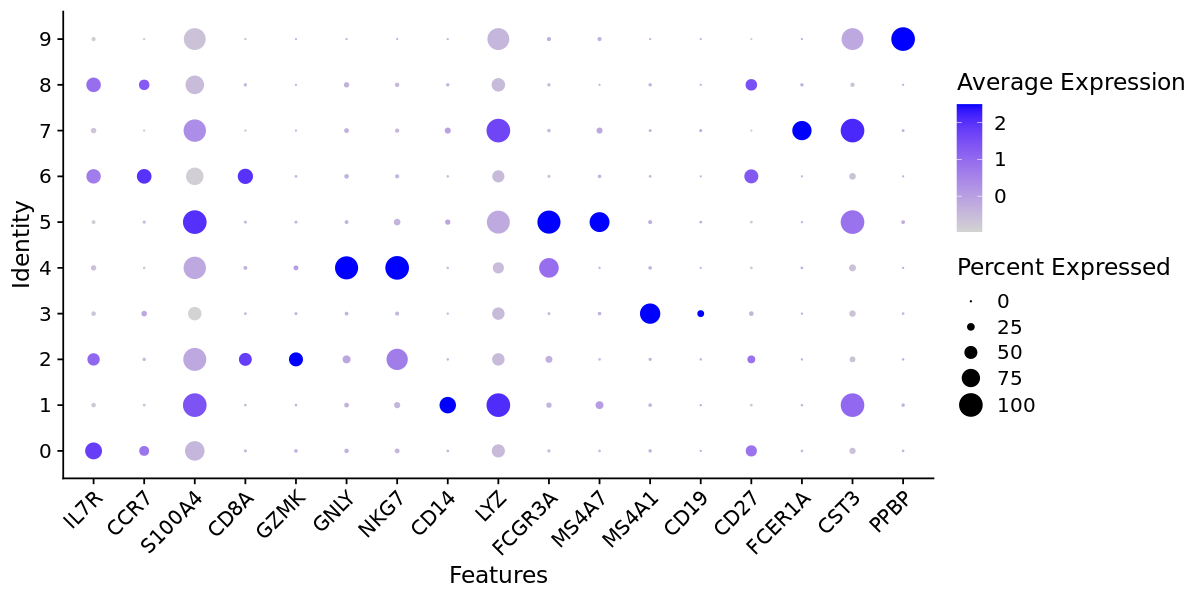

In [22]:
options(repr.plot.width=10, repr.plot.height=5)
DotPlot(pbmc, features = unique(c(CD4.naive.markers,CD4.memory.markers,CD8.markers,
                                  NK.markers,Classic.Monocyte.markers,
                                  FCGR3Apos.Monocyte.markers,Bcell.markers,
                                  Dendritic.markers,Megakarocyte.markers))) + RotatedAxis()

Based on our list of known marker genes and the above gene expression plots, we can assign identities to the clusters from "SCT_snn_res.0.7".  We can then add a column to the `pbmc@meta.data` table to store those cluster IDs.

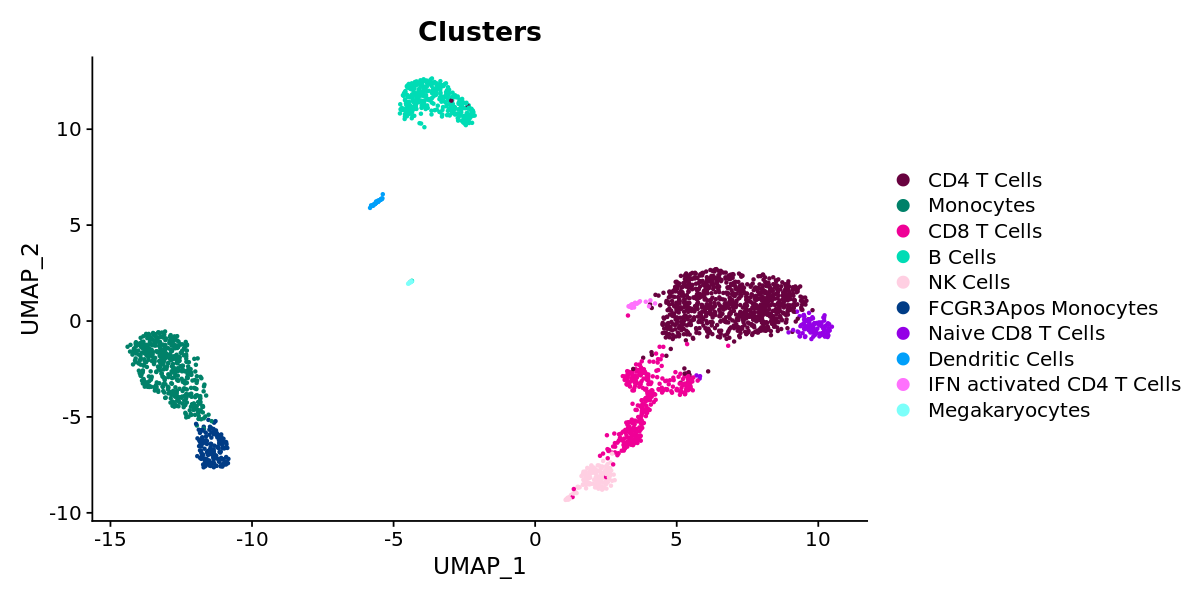

In [23]:
pbmc <- RenameIdents(pbmc,
                     "0" = "CD4 T Cells",
                     "1" = "Monocytes",
                     "2" = "CD8 T Cells",
                     "3" = "B Cells",
                     "4" = "NK Cells",
                     "5" = "FCGR3Apos Monocytes",
                     "6" = "Naive CD8 T Cells",
                     "7" = "Dendritic Cells",
                     "8" = "IFN activated CD4 T Cells",
                     "9" = "Megakaryocytes")
pbmc$Clusters <- Idents(pbmc)
DimPlot(pbmc, group.by = "Clusters", cols = cbpal18)

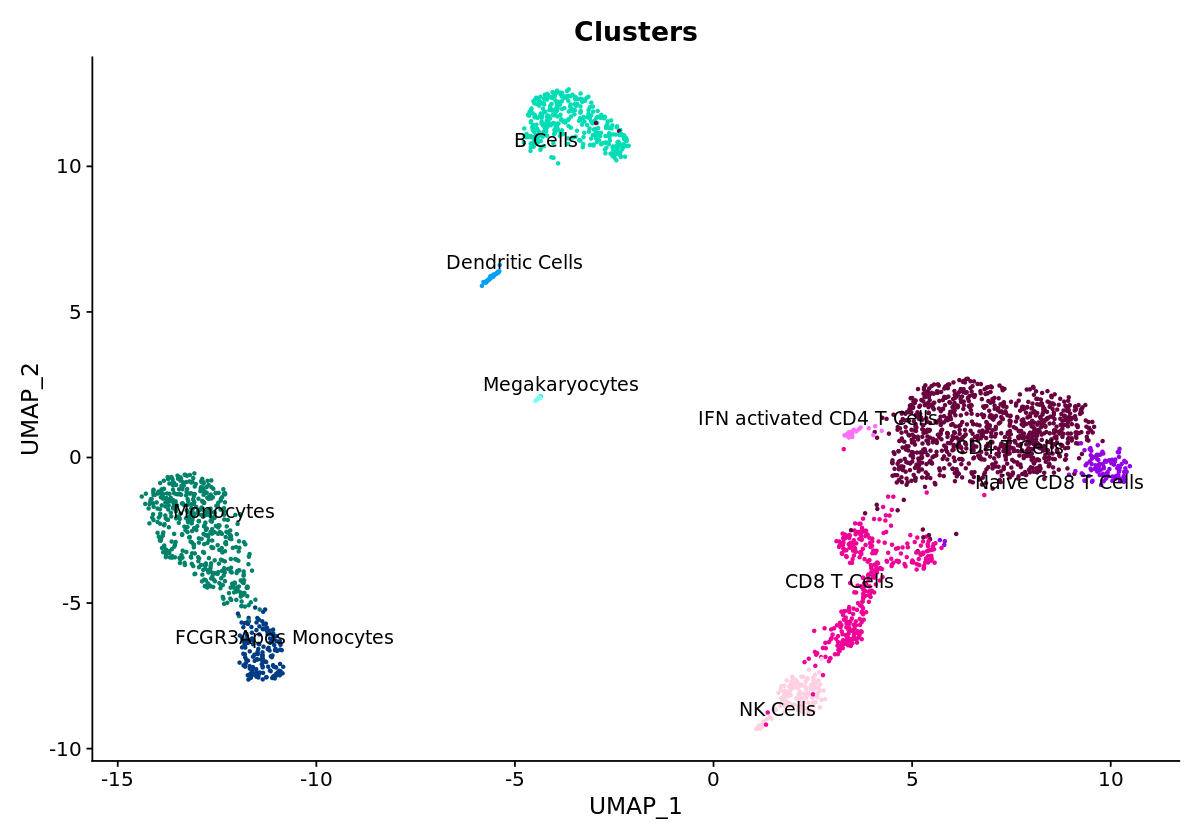

In [24]:
options(repr.plot.width=10, repr.plot.height=7)
DimPlot(pbmc, group.by = "Clusters", cols = cbpal18, label = T, repel = T) + NoLegend()

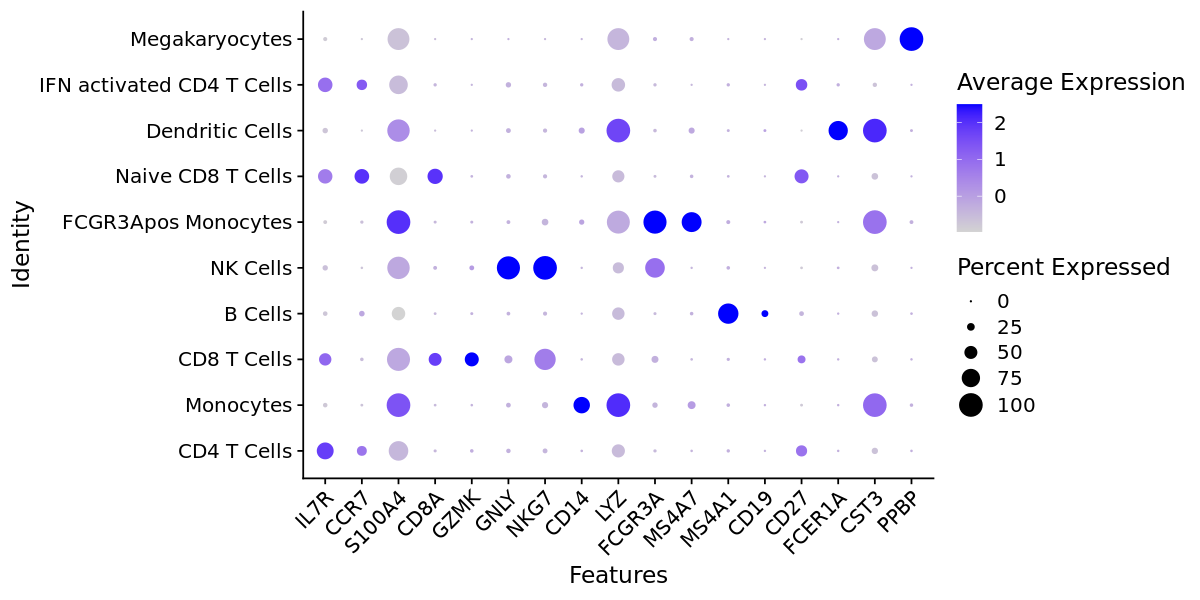

In [25]:
options(repr.plot.width=10, repr.plot.height=5)
DotPlot(pbmc, features = unique(c(CD4.naive.markers,CD4.memory.markers,CD8.markers,
                                  NK.markers,Classic.Monocyte.markers,
                                  FCGR3Apos.Monocyte.markers,Bcell.markers,
                                  Dendritic.markers,Megakarocyte.markers))) + RotatedAxis()

# 6 Gene Set Expression Plots

The Seurat tutorial vignettes only use individual gene expression plots to identify cluster cell types, but it can be useful to use a group of cell type markers.  I have written a couple of functions to make plots similar to those from `scanpy` colored by mean gene expression of a set of genes.  To use these functions simply make sure they are copied into your code somewhere before they are called.  I typically put them right after the chunk of code with the library setup.  `CreateUMAPmetadataDF()` takes a SeuratObject and creates a data frame which is a copy of the meta.data table with the umap coordinates added and returns this data frame.  `ColorByGeneSet()` takes a gene list, the data frame created above and a SeuratObject and finds the mean expression of the genes in the gene list.  It then creates a ggplot scatter plot using the umap coordinates as the x and y coordinates and points colored by the mean gene expression and returns this plot.  Note, since it returns only the plot and not the data frame, the mean gene expression is not saved in the data frame and so the same data frame can be used over again for another gene set expression plot.

In [26]:
CreateUMAPmetadataDF <- function(object){
  umap.coord <- as.data.frame(object[['umap']]@cell.embeddings)
  df <- object@meta.data
  df$UMAP_1 <- umap.coord$UMAP_1
  df$UMAP_2 <- umap.coord$UMAP_2
  
  return(df)
}

ColorByGeneSet <- function(genelist, df, object) {
  mydata <- FetchData(object, vars = genelist)
  mydata$mean <- rowMeans(mydata)
  df$mean <- mydata$mean
  plot <- ggplot(df, aes(x=UMAP_1, y=UMAP_2, color=mean)) + geom_point(size = 0.3)
  
  plot <- plot + theme_classic() + 
    scale_color_gradient(low="lightgrey",high="blue") 
  
  return(plot)
}

We can use these functions to color a UMAP plot by the mean expression of the genes in the various markers vectors.  First, we will make a list consisting of the various vectors of marker genes and then add a name to each item in the list.  Next we will use `CreateUMAPmetadataDF()` to create a data frame of the UMAP coordinates for each cell.  The R function `lapply()` applies a function, in this case `ColorByGeneSet()`, over each item in a list, in this case `marker.list` and returns a list where each item in the list is the return of the function.  So, for our list `marker.list` the first item in the list is the vector named "CD4.naive" containing c("IL7R","CCR7").  The first item in the list pbmc.marker.plots created from `lapply()` here is the UMAP plot of the mean gene expression of IL7R and CCR7 returned from `ColorByGeneSet()` using this "CD4.naive" vector.  The items in the list returned from `lapply()` are given the same names as those of the list for the input of `lapply()`.  The final step takes each of the plots in the list `pbmc.marker.plots` and adds a title which is the name of the item in the list plus "Gene Set Expression" and then uses the `patchwork` function `wrap_plots()` to print all the plots in the list together.

In [27]:
marker.list <- list(CD4.naive.markers,CD4.memory.markers,CD8.markers,
                                  NK.markers,Classic.Monocyte.markers,
                                  FCGR3Apos.Monocyte.markers,Bcell.markers,
                                  Dendritic.markers,Megakarocyte.markers)
names(marker.list) <- c('CD4.naive','CD4.memory','CD8',
                        'NK','Classic.Monocyte',
                        'FCGR3Apos.Monocyte','Bcell',
                        'Dendritic','Megakarocyte')

In [28]:
pbmc.umap.df <- CreateUMAPmetadataDF(pbmc)
pbmc.marker.plots <- lapply(marker.list, ColorByGeneSet, df = pbmc.umap.df, object = pbmc)

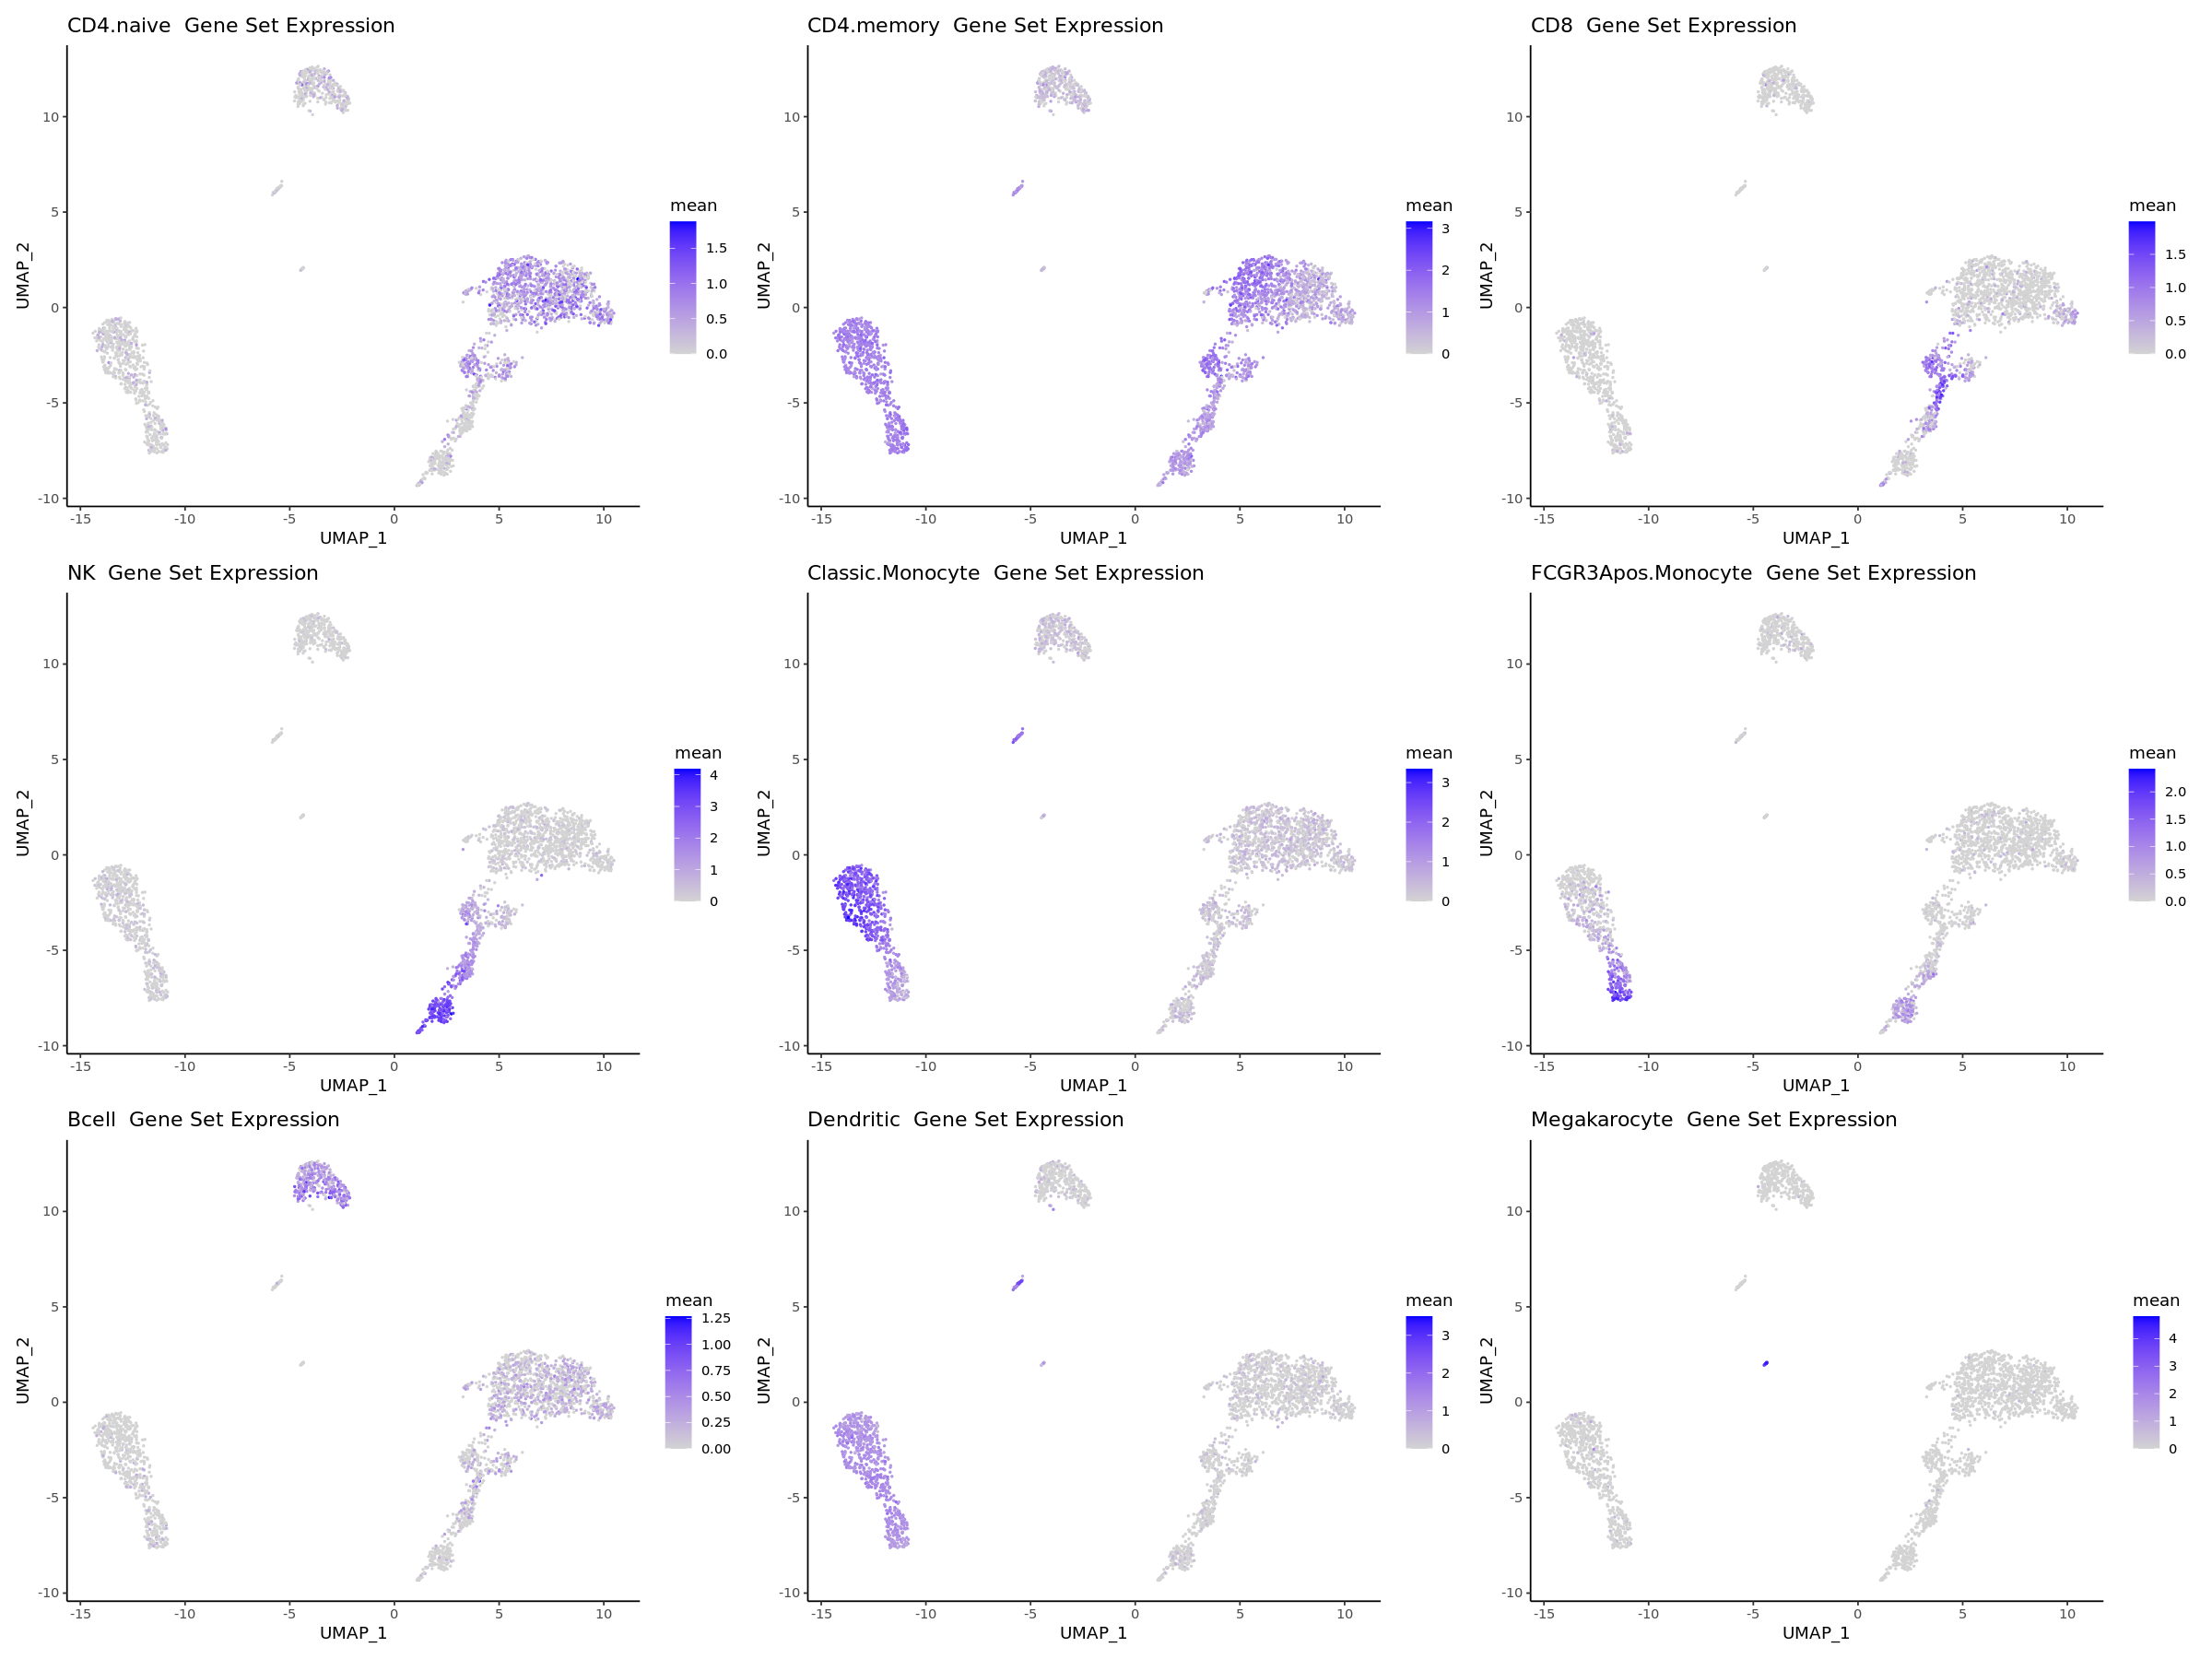

In [29]:
options(repr.plot.width=20, repr.plot.height=15)
for(cluster in names(pbmc.marker.plots)){
    pbmc.marker.plots[[cluster]] <- pbmc.marker.plots[[cluster]] + ggtitle(paste(cluster, " Gene Set Expression"))
}
wrap_plots(pbmc.marker.plots)

# 7 Cluster Manipulation

Sometimes it might be justified to manipulate your clusters. This could entail removing clusters from your dataset (they look stressed/dying, they are small and confounding, they are not important for your individual analysis, etc.), merging similar clusters, and splitting individual clusters to tease apart cell subtypes that might have initially been clustered together. Let's go through some examples with our dataset.

## Removing Clusters

For the sake of practice, let's filter out the Dendritic Cells cluster.

In [30]:
pbmc <- subset(pbmc, idents="Dendritic Cells", invert = TRUE)

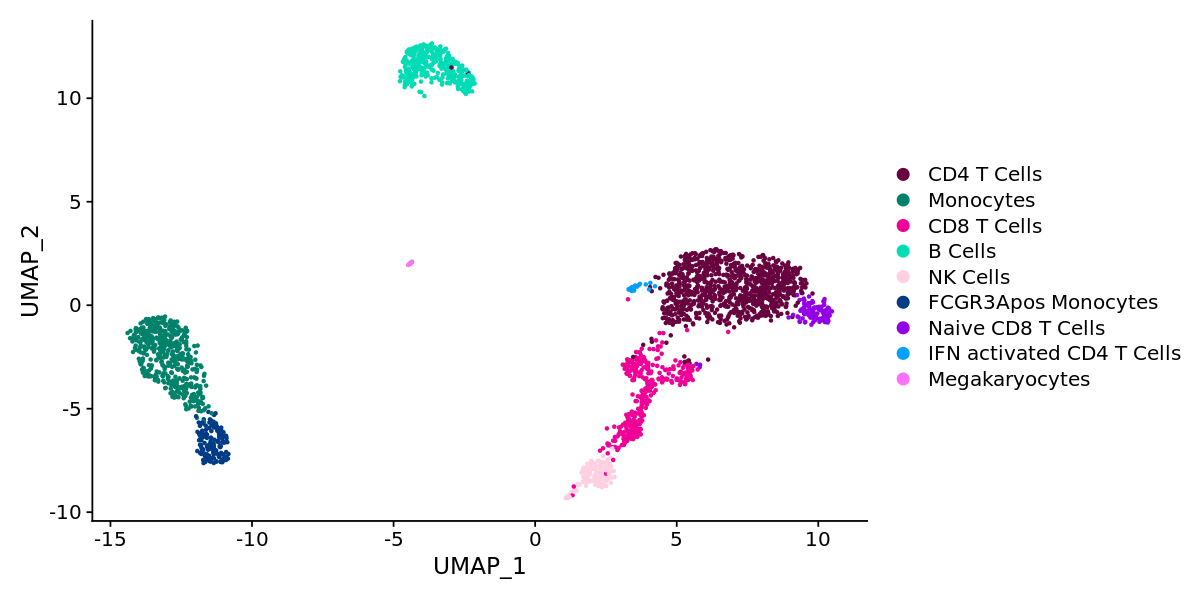

In [31]:
options(repr.plot.width=10, repr.plot.height=5)
DimPlot(pbmc, cols = cbpal18)

## Merging Clusters

For the sake of practice, let's merge clusters CD14+ Monocytes and FCGR3A+ Monocytes.

In [32]:
pbmc$FinalClusters <- pbmc$Clusters
pbmc$FinalClusters[pbmc$FinalClusters == "Monocytes" | 
                   pbmc$FinalClusters == "FCGR3Apos Monocytes"] = "Monocytes"

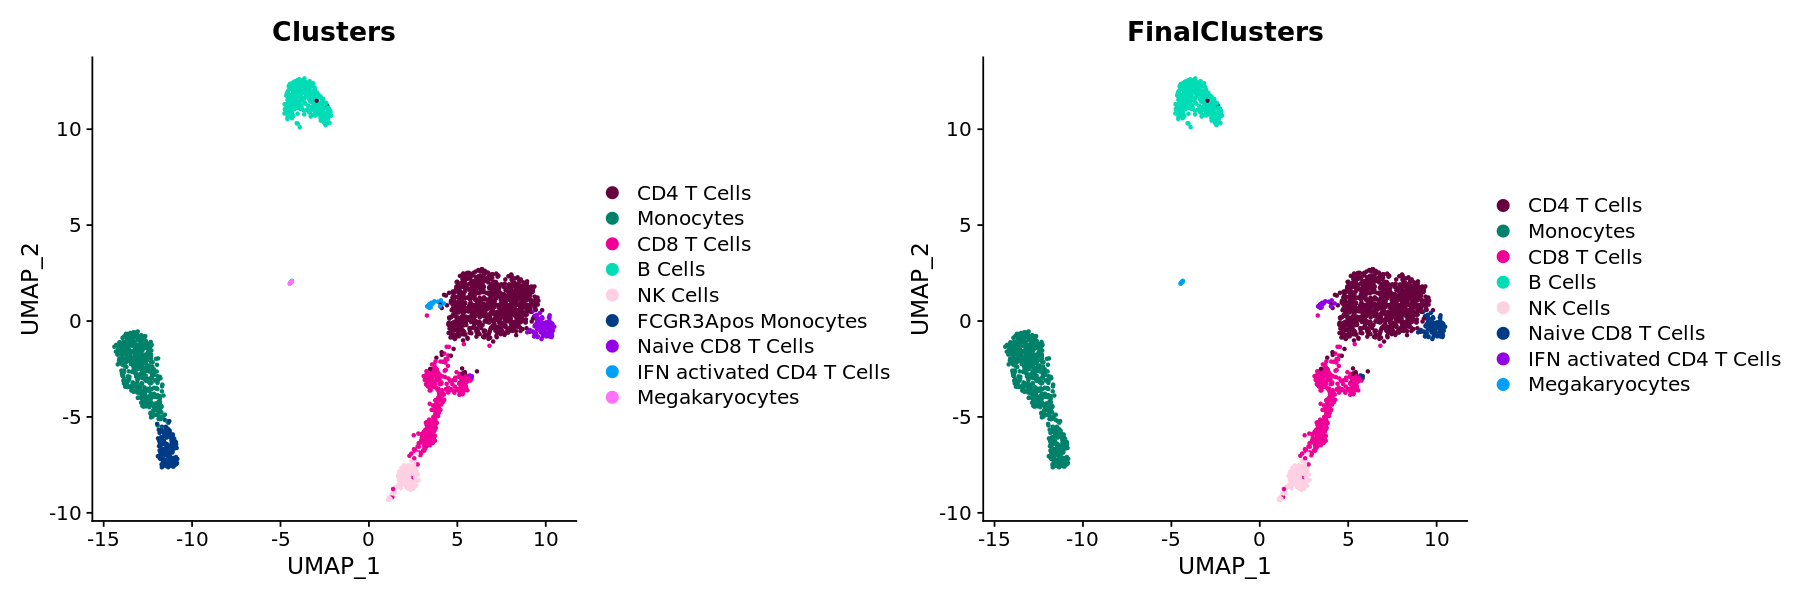

In [33]:
options(repr.plot.width=15, repr.plot.height=5)
p1 <- DimPlot(pbmc, group.by = "Clusters", cols = cbpal18)
p2 <- DimPlot(pbmc, group.by = "FinalClusters", cols = cbpal18)
p1 + p2

## Splitting Clusters

For the sake of practice, let's separate the CD8 T Cells into two clusters.  Let's look again at resolution 0.8 clusters and the gene expression plots of CD8A, CCL5, GZMK, and GZMH.

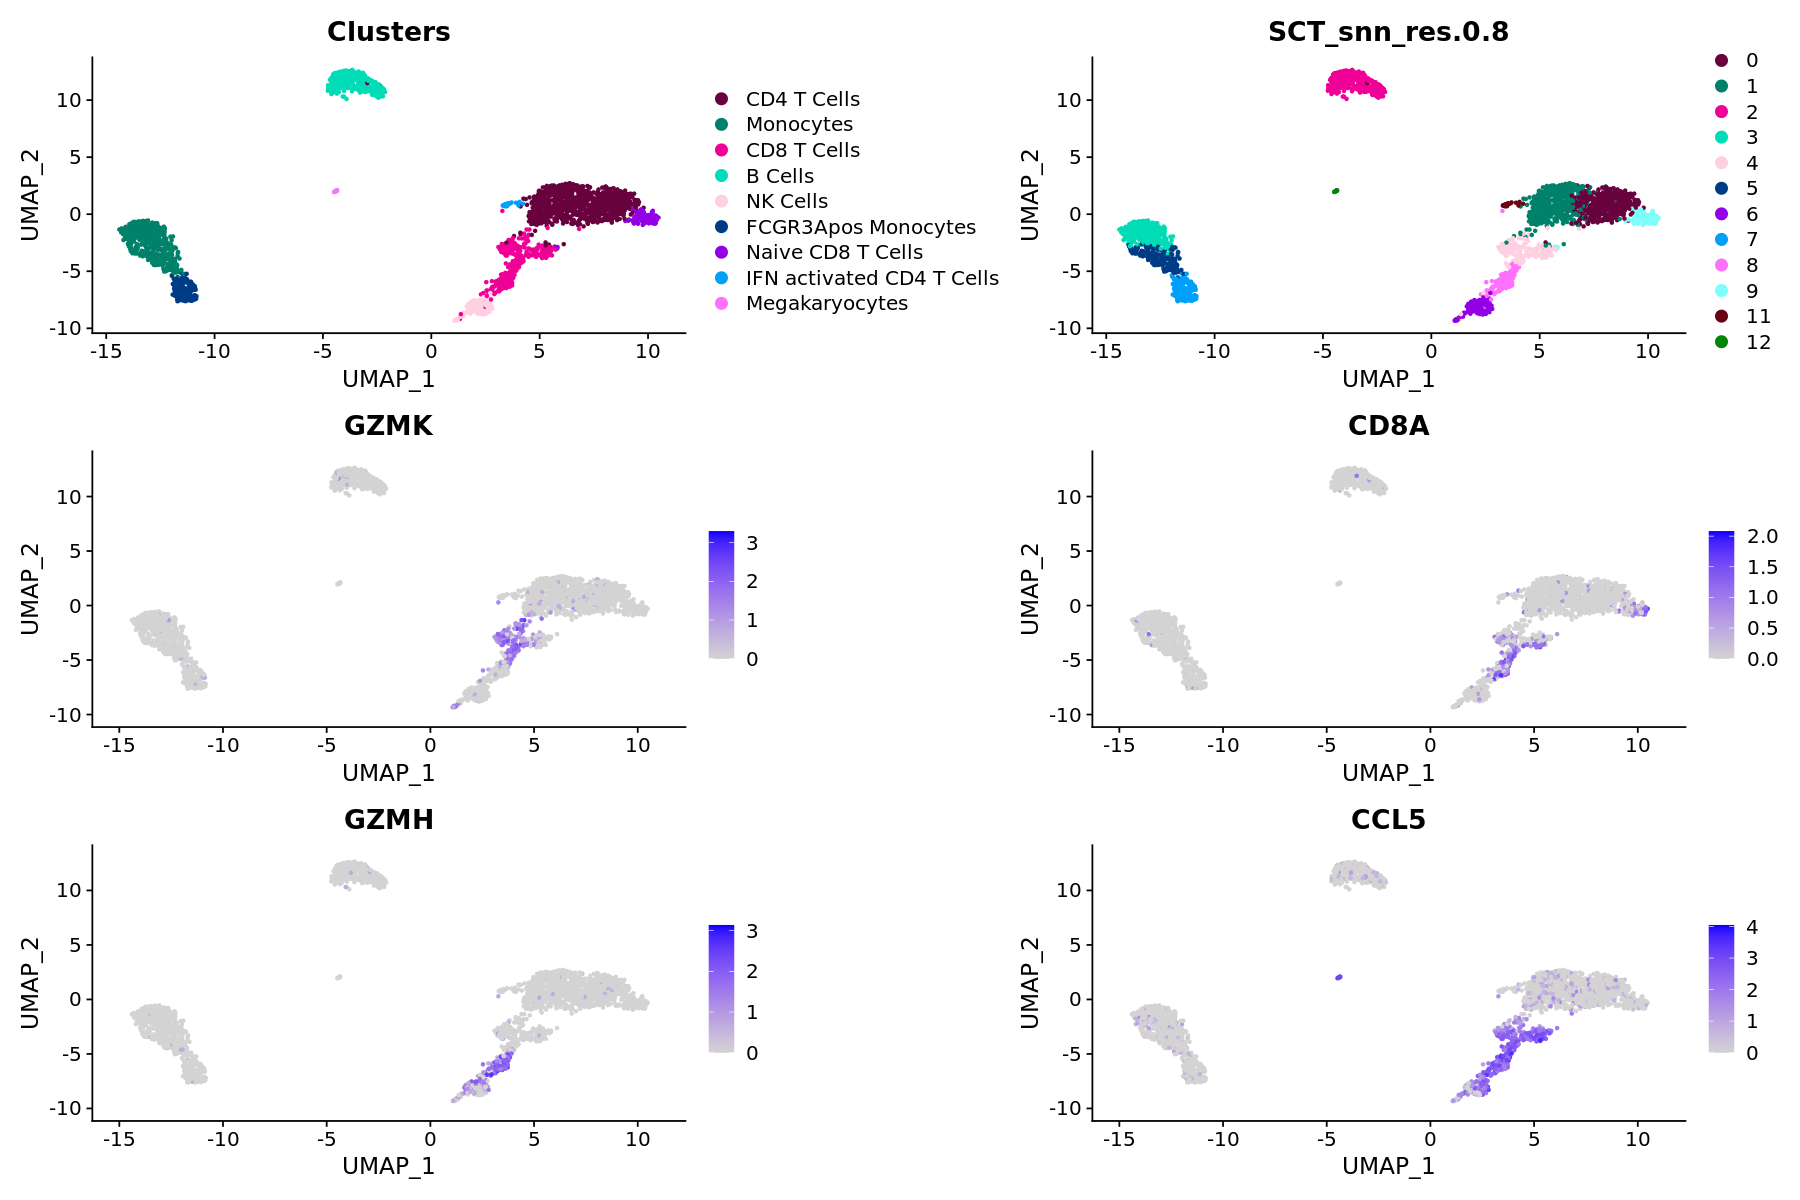

In [34]:
options(repr.plot.width=15, repr.plot.height=10)
p1 <- DimPlot(pbmc, group.by = "Clusters", cols = cbpal18)
p2 <- DimPlot(pbmc, group.by = "SCT_snn_res.0.8", cols = cbpal18)
p3 <- FeaturePlot(pbmc, feature = "GZMK")
p4 <- FeaturePlot(pbmc, feature = "CD8A")
p5 <- FeaturePlot(pbmc, feature = "GZMH")
p6 <- FeaturePlot(pbmc, feature = "CCL5")
(p1 + p2 + p3 + p4 + p5 + p6) + plot_layout(ncol = 2)

At resolution 0.8 the cluster "CD8 T Cells" is split into two clusters corresponding to the expression of GZMK or GZMH.  However at this resolution the "CD4 T Cells" and "Monocytes" clusters are also split into multiple clusters.  Let's say we are only interested in splitting the "CD8 T Cells" cluster.  

In [35]:
pbmc$FinalClusters <- as.character(pbmc$FinalClusters)
pbmc$FinalClusters[pbmc$SCT_snn_res.0.8 == '4'] <- "GZMKpos CD8 T Cells"
pbmc$FinalClusters[pbmc$SCT_snn_res.0.8 == '8'] <- "GZMHpos CD8 T Cells"
pbmc$FinalClusters <- as.factor(pbmc$FinalClusters)

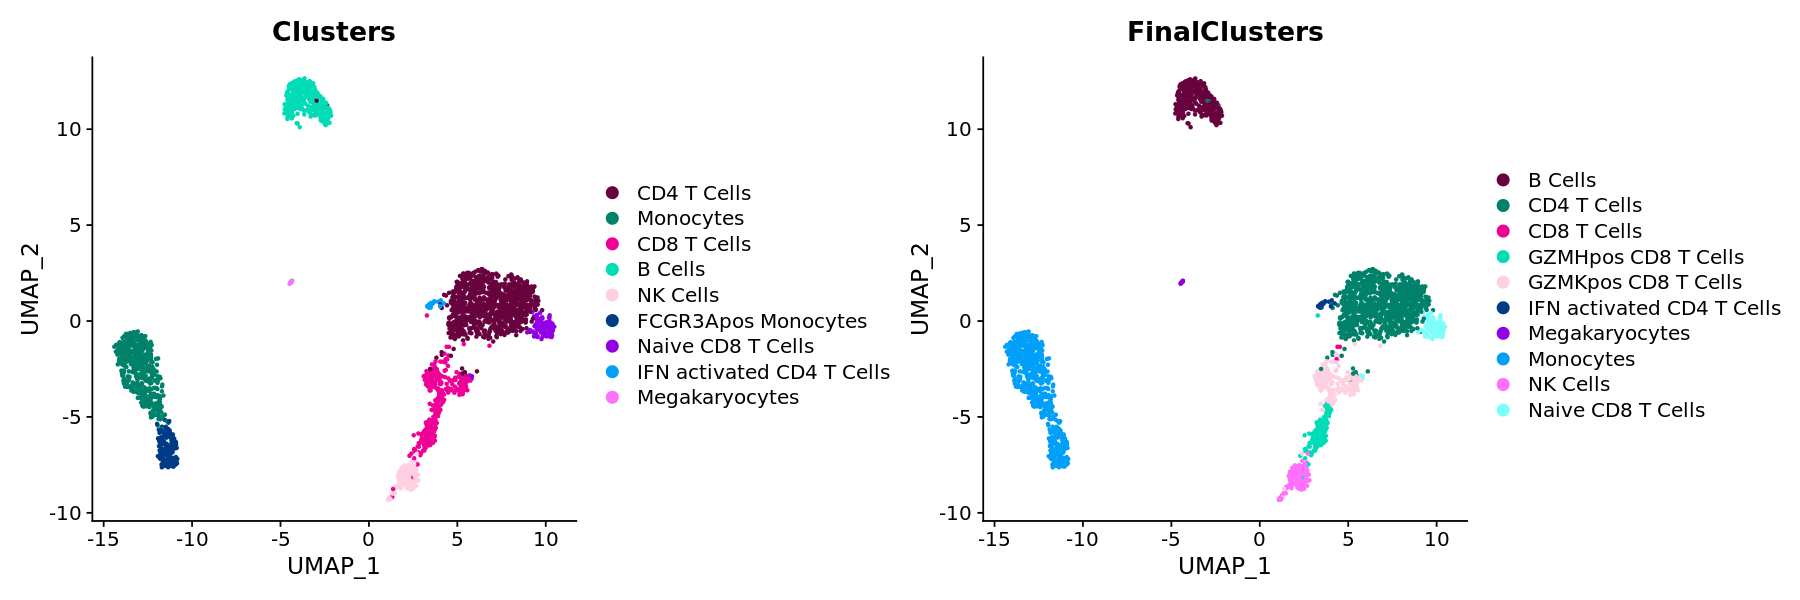

In [36]:
options(repr.plot.width=15, repr.plot.height=5)
p1 <- DimPlot(pbmc, group.by = "Clusters", cols = cbpal18)
p2 <- DimPlot(pbmc, group.by = "FinalClusters", cols = cbpal18)
p1 + p2

Note, we could have gotten these same FinalClusters by starting with SCT_snn_res.0.8 and naming clusters '3','5' and '7', "Monocytes" and naming clusters '0' and '1', "CD4 T Cells".

# 8 Summary

Congrats! Another tutorial down! You're well on your way to being a bioinformatics pro! In summary, this tutorial introduced you to all things clusters - how to generate clusters, how to annotate clusters based on data-deriven and known marker genes, and how to manipulate your clusters based on your experiment and specific questions (don't abuse that power! The more hands-off you can be with a dataset and the more unbiased it is the better!). Check out the Appendix for a few more things you can do with your clusters. And as always, (sorry this has been repeated so many times but...) there is no "one size fits all" approach to scRNA-seq analysis. You need to do what's best for your specific dataset and for your specific biological questions.

Next up, pseudotime analysis (our last tutorial for this workshop)!

In [37]:
# Finally let's save our annotated, clustered pbmc SeuratObject.
saveRDS(pbmc, file = "output/pbmc.clustered.RDS")

# Appendix

## Subsetting Data

If we are only interested in a subset of our data, we can easily subset our adata object to just those clusters of interest. For example, let's subset just the T Cell clusters in our sample data.

In [38]:
Idents(pbmc) <- "Clusters"
pbmc.tcells <- subset(pbmc, idents = c("CD4 T Cells",
                                       "Naive CD8 T Cells",
                                       "CD8 T Cells",
                                       "IFN activated CD4 T Cells"))

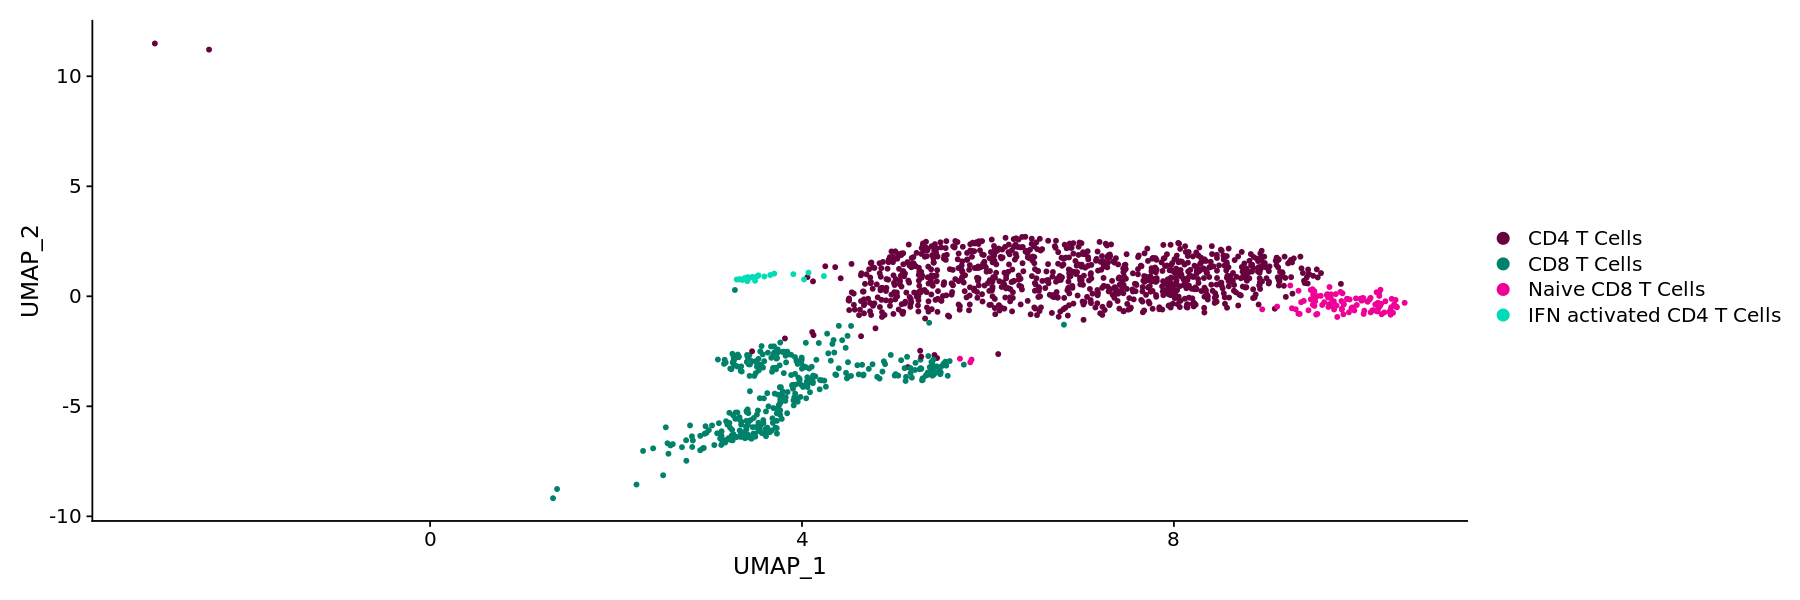

In [39]:
DimPlot(pbmc.tcells, cols = cbpal18)

In [40]:
rm(pbmc) ## this step is necessary for this docker jupyter notebook to keep the R kernel from terminating

We can also take our subsetted data and re-cluster it into its own UMAP space, which might provide some additional insight into cell subtypes. To do this, we would find the highly variable genes for our subsetted data and compute new PCA, neighbors, and UMAP coordinates, and do a new cluster analysis.

In [41]:
options(warn=-1)
pbmc.tcells <- SCTransform(pbmc.tcells, vars.to.regress = "percent.mt", verbose = FALSE) %>%
    RunPCA(features = VariableFeatures(object = pbmc.tcells)) %>% 
    RunUMAP(dims = 1:30, verbose = FALSE) %>%
    FindNeighbors(dims = 1:30) %>%
    FindClusters(resolution = 0.5) %>%
    FindClusters(resolution = 0.7) %>%
    FindClusters(resolution = 0.8)

PC_ 1 
Positive:  CCL5, NKG7, CST7, GZMH, GZMA, B2M, GZMB, FGFBP2, CTSW, PRF1 
	   GZMK, HLA-C, ACTB, CCL4, GNLY, HLA-DPB1, CD8A, SRGN, HLA-A, FCGR3A 
	   PFN1, S100A4, SH3BGRL3, HLA-DRB1, CYBA, CLIC1, LGALS1, APOBEC3G, KLRG1, LYAR 
Negative:  RPL13, RPS6, RPS12, RPS3A, RPL34, JUNB, RPL11, RPS18, TPT1, RPL13A 
	   RPS13, RPL9, RPL19, LTB, RPS2, RPL10A, RPS5, RPL21, RPL18, RPL3 
	   CCR7, RPS27A, RPS9, LDHB, RPL5, FOS, NOSIP, RPL8, RPS3, C6orf48 
PC_ 2 
Positive:  S100A4, LTB, TMSB4X, VIM, S100A11, ACTB, IL32, B2M, LGALS1, ANXA1 
	   S100A10, KLF6, ISG15, ANXA2, PLP2, TNFRSF4, DUSP1, ACTG1, COTL1, FOS 
	   JUN, LGALS3, ZFP36, ALOX5AP, S100A6, AQP3, NFKBIA, GAPDH, CORO1B, SAT1 
Negative:  NKG7, CCL5, GZMH, CD8B, MALAT1, RPS3A, RPS6, CST7, CD8A, FGFBP2 
	   RPL21, RPL13, RPL3, GZMB, RPS3, RPS12, CTSW, RPL9, CCL4, RPS27A 
	   RPL19, RPS5, RPS2, RPL13A, RPL5, RP11-291B21.2, RPS13, RPL10A, FCGR3A, RPS18 
PC_ 3 
Positive:  GZMK, CCL5, NCR3, FOS, JUN, DUSP1, ID2, NFKBIA, IL7R, LYAR 
	   IER2, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1455
Number of edges: 70607

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7456
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1455
Number of edges: 70607

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6866
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1455
Number of edges: 70607

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6630
Number of communities: 7
Elapsed time: 0 seconds


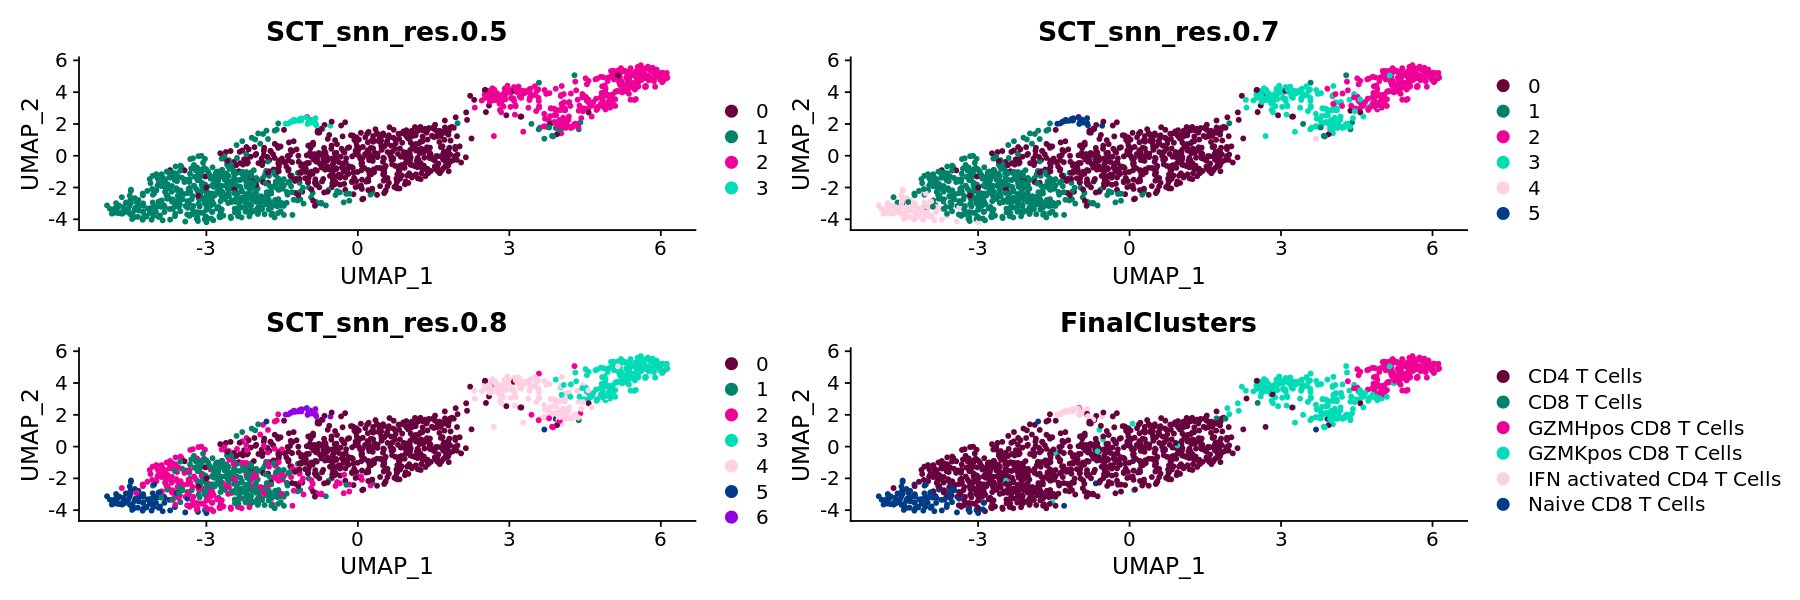

In [42]:
p1 <- DimPlot(pbmc.tcells, group.by = "SCT_snn_res.0.5", cols = cbpal18)
p2 <- DimPlot(pbmc.tcells, group.by = "SCT_snn_res.0.7", cols = cbpal18)
p3 <- DimPlot(pbmc.tcells, group.by = "SCT_snn_res.0.8", cols = cbpal18)
p4 <- DimPlot(pbmc.tcells, group.by = "FinalClusters", cols = cbpal18)
p1 + p2 + p3 + p4

You can see that in this example the reprocessing of the T cell clusters did not change the cell clustering much from the "FinalClusters" of the full pbmc dataset except for splitting the CD4 T Cells cluster which was split into 2 clusters at "SCT_snn_res_0.8" in the full pbmc dataset.  

## Additional Plotting Tools

Seurat offers other ways to visualize data. Some plots can be more informative than others depending on your data and specific questions, and sometimes what plots you use might just come down to personal preference. Below are some examples. Play around with these different types of plots to visualize your data in different ways!

### Ridge Plot

Picking joint bandwidth of 0.137

Picking joint bandwidth of 0.0877

Picking joint bandwidth of 0.137

Picking joint bandwidth of 0.246

Picking joint bandwidth of 0.0872

Picking joint bandwidth of 0.129



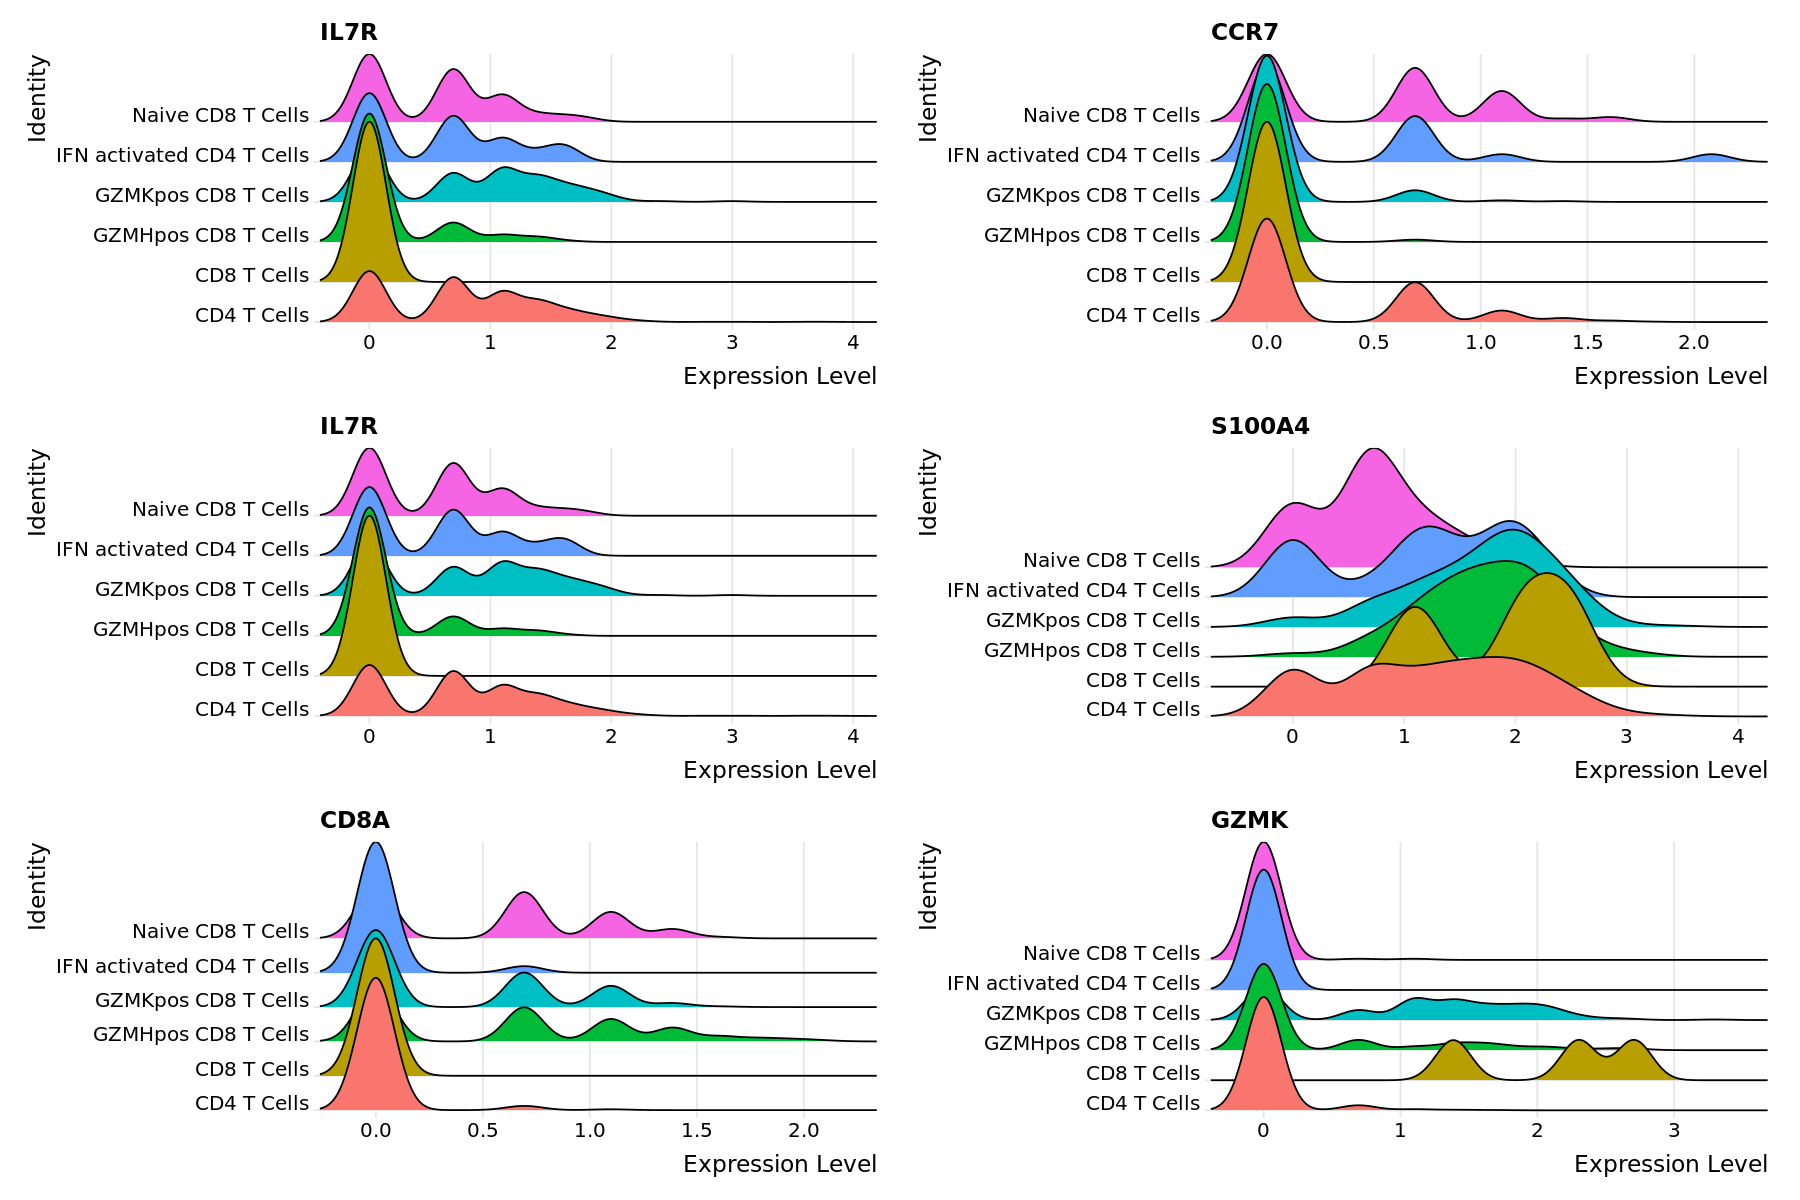

In [43]:
options(repr.plot.width=15, repr.plot.height=10)
Idents(pbmc.tcells) <- "FinalClusters"
RidgePlot(pbmc.tcells, features = c(CD4.naive.markers,CD4.memory.markers,CD8.markers), ncol = 2)

### Heatmap

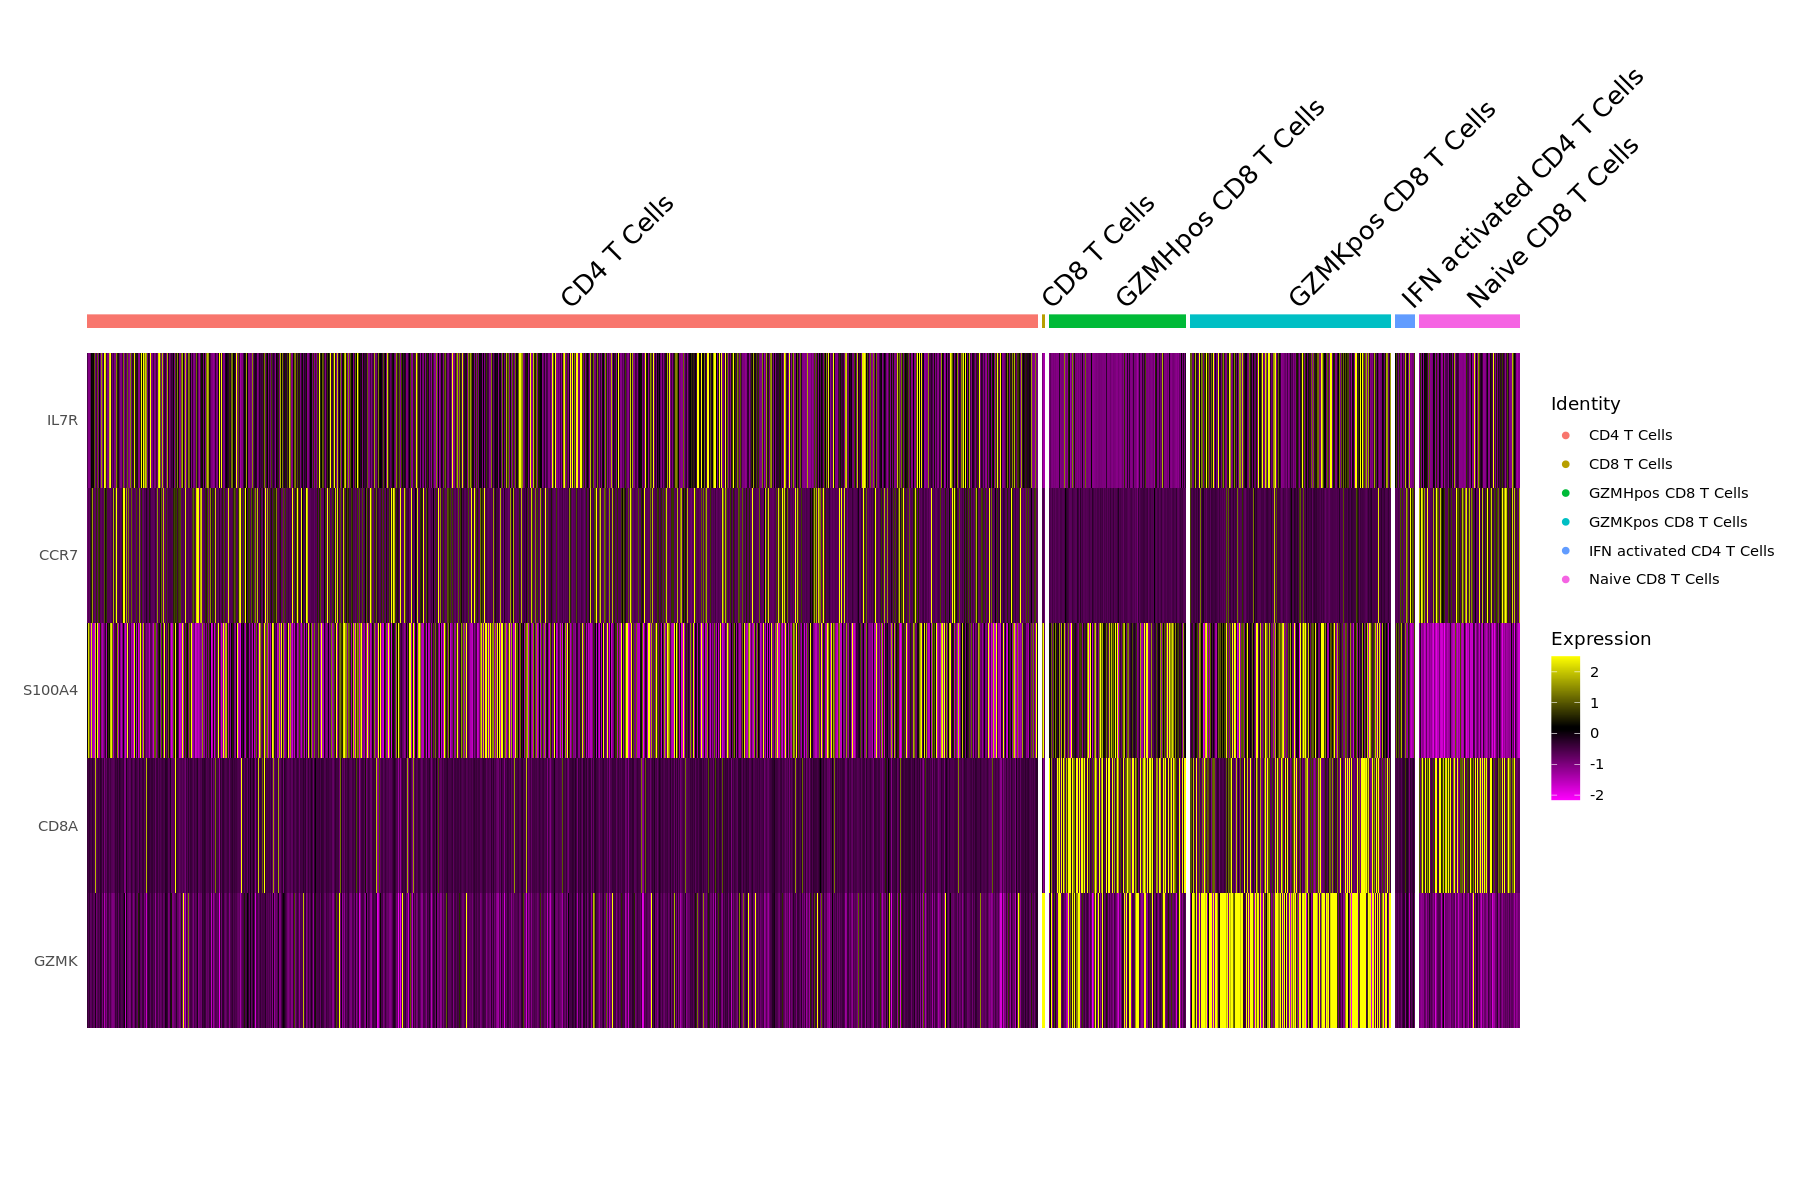

In [44]:
DoHeatmap(pbmc.tcells, features = c(CD4.naive.markers,CD4.memory.markers,CD8.markers))

### Additional options for FeaturePlot

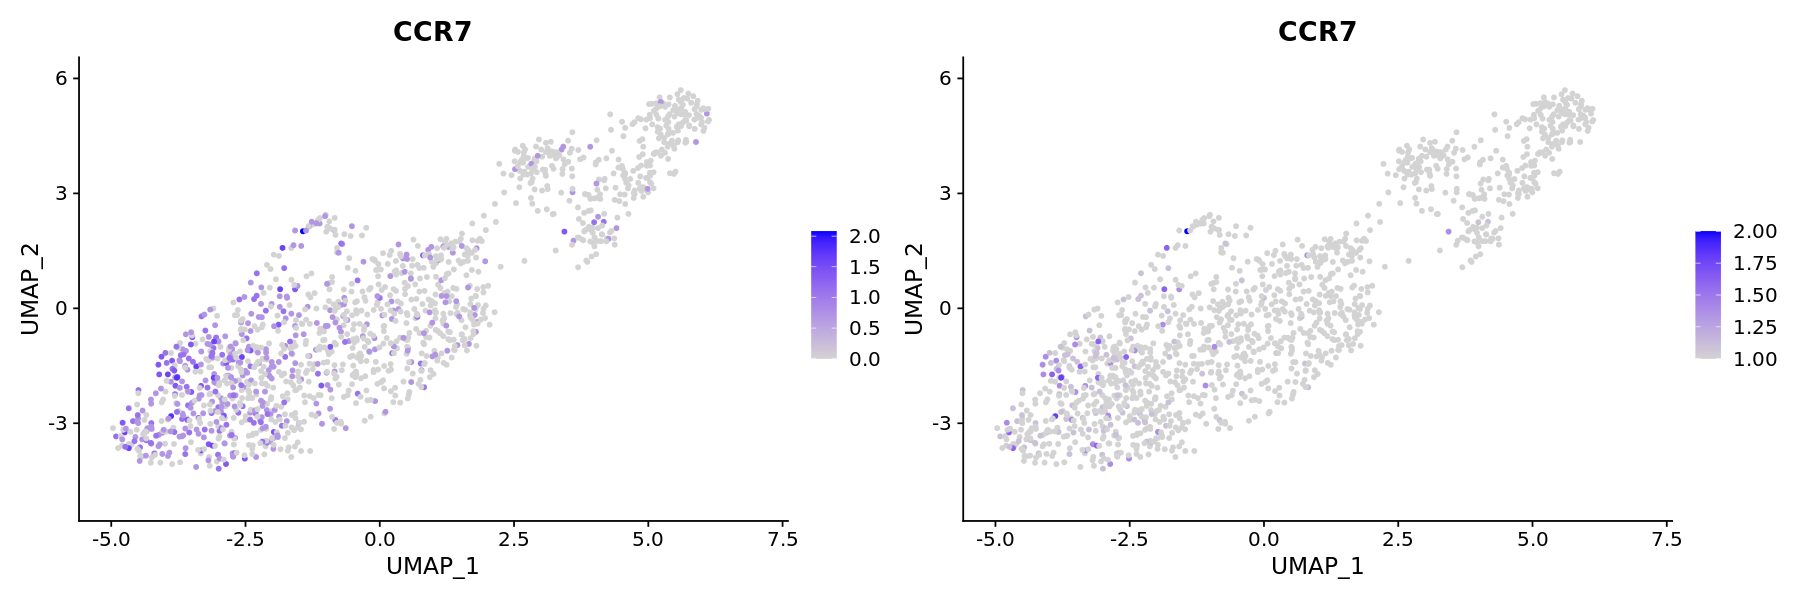

In [45]:
options(repr.plot.width=15, repr.plot.height=5)
p1 <- FeaturePlot(pbmc.tcells, features = "CCR7")
p2 <- FeaturePlot(pbmc.tcells, features = "CCR7", min.cutoff = 1, max.cutoff = 2)
p1 + p2 + plot_layout(ncol = 2)

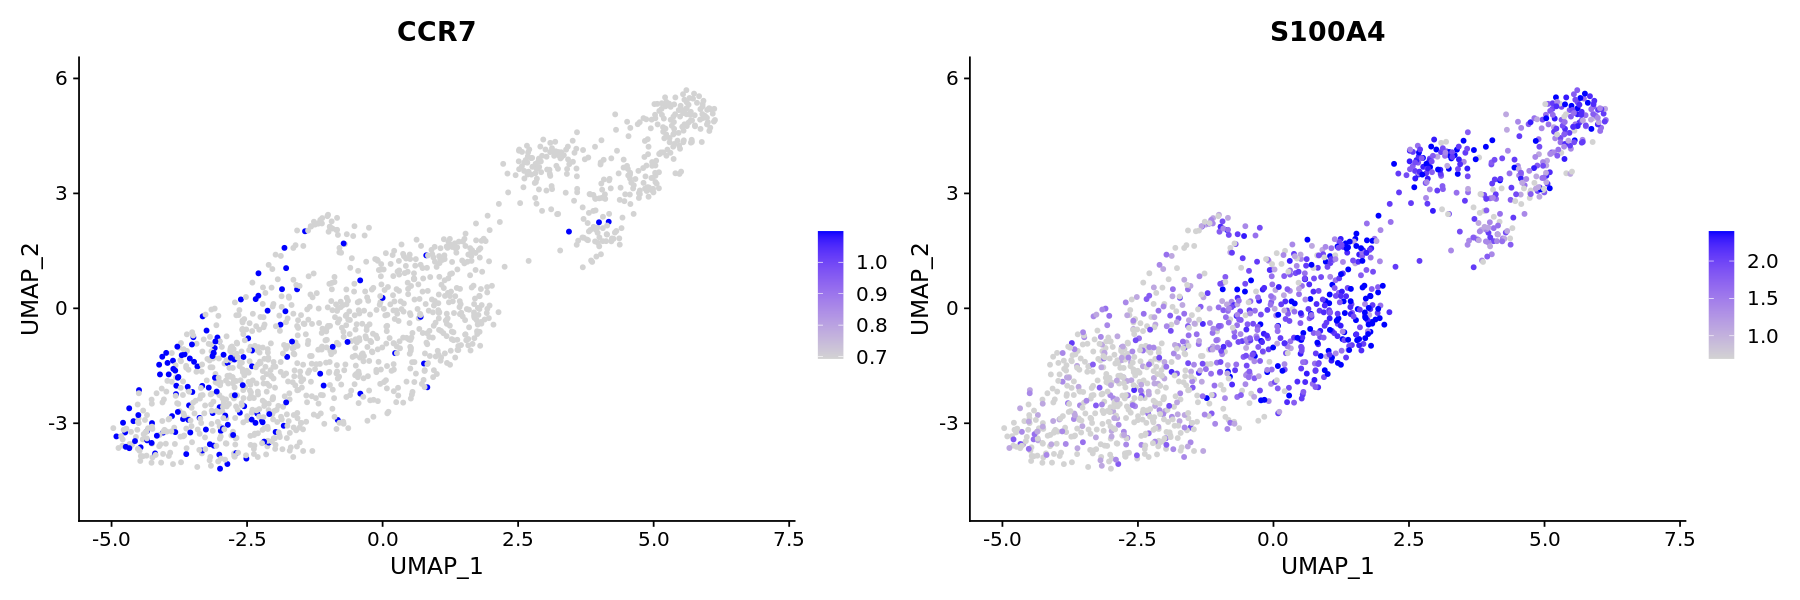

In [46]:
FeaturePlot(pbmc.tcells, features = c("CCR7","S100A4"), min.cutoff = "q10", max.cutoff = "q90")

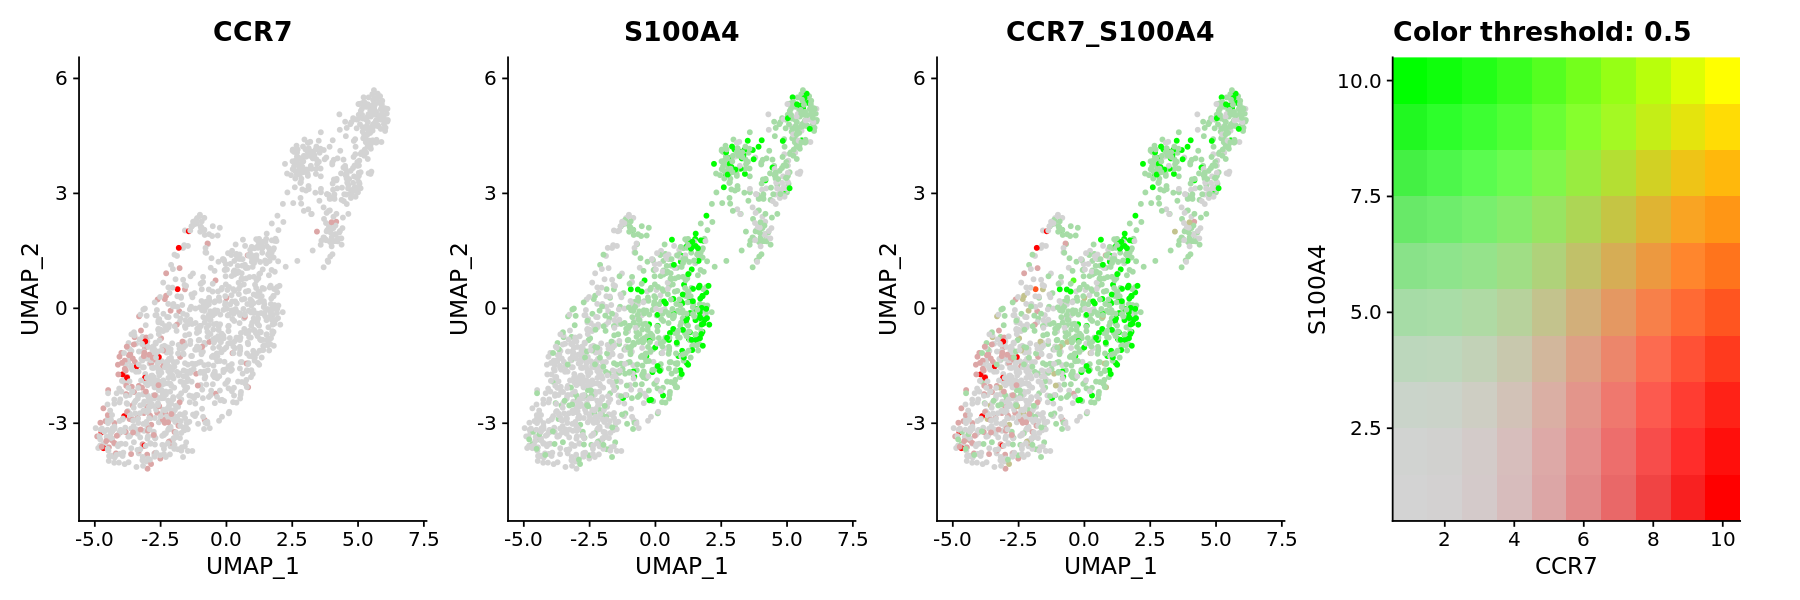

In [47]:
FeaturePlot(pbmc.tcells, features = c("CCR7","S100A4"), blend = TRUE)

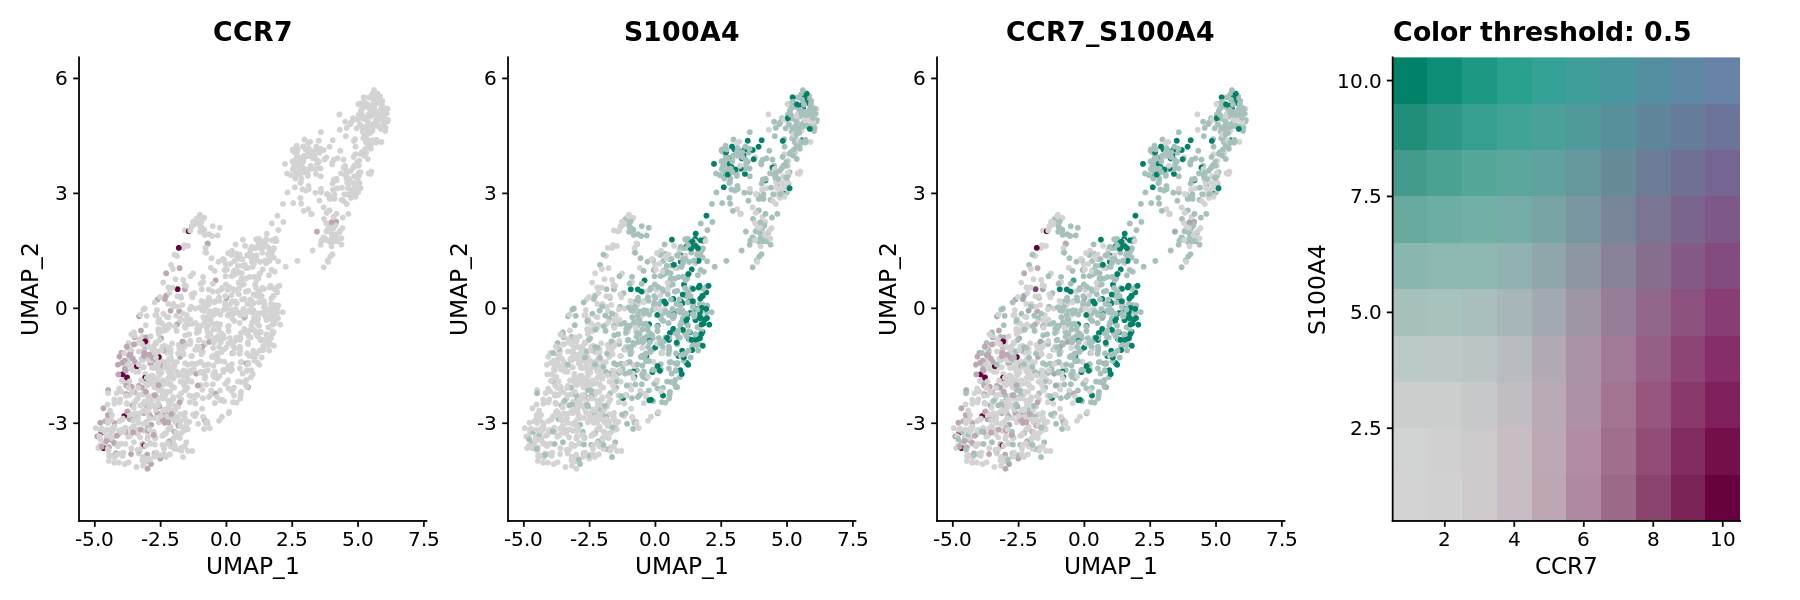

In [48]:
FeaturePlot(pbmc.tcells, features = c("CCR7","S100A4"), blend = TRUE, 
                  cols = c("lightgrey", cbpal18[1], cbpal18[2]))

### Additional cell mappings

The default dimentional reduction map displayed by DimPlot is 'umap', but DimPlot can also be used to display the cells mapped with PC or tSNE coordinates using the 'reduction' argument.  Typically the first and second dimentions are used for the x and y coordinates, but any dimensions can be selected using the 'dims' argument.

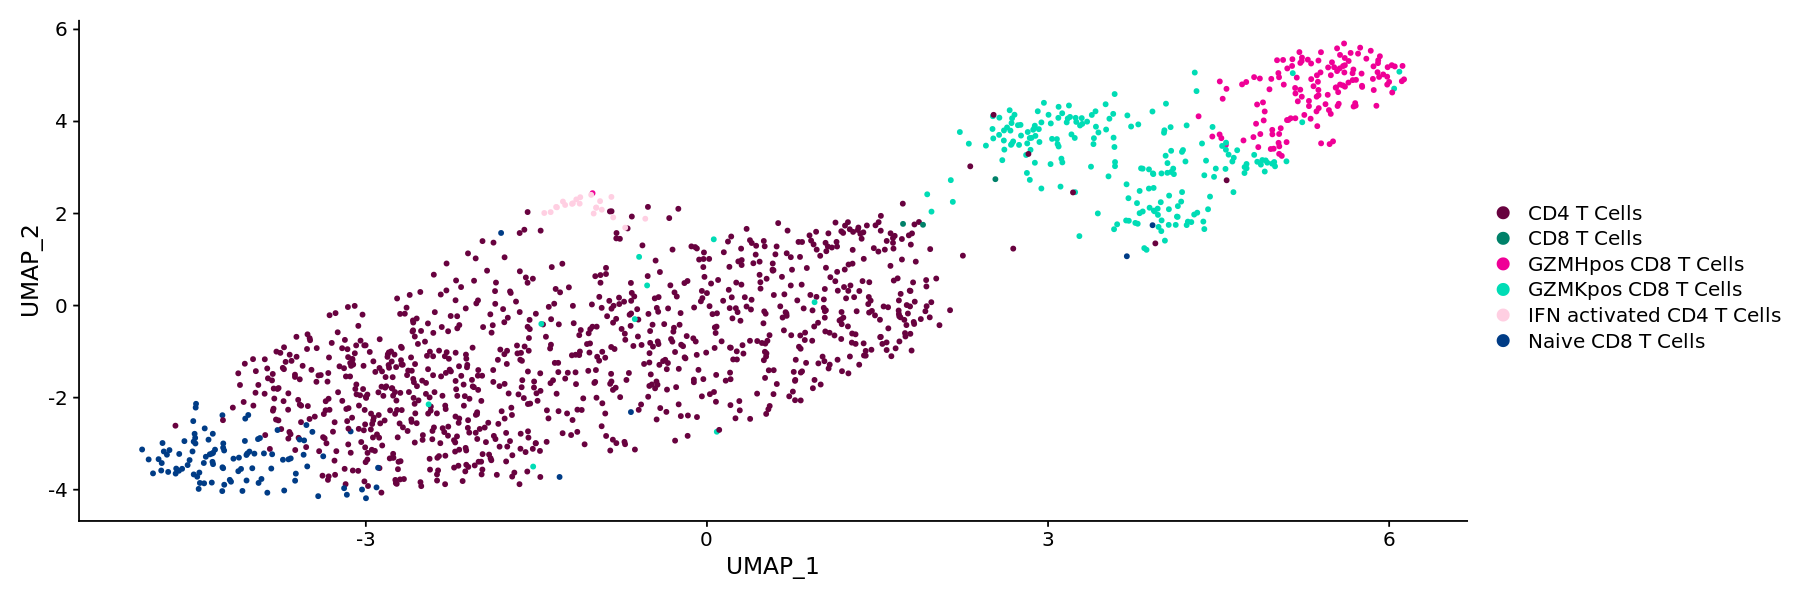

In [49]:
p1 <- DimPlot(pbmc.tcells, cols = cbpal18)
p1

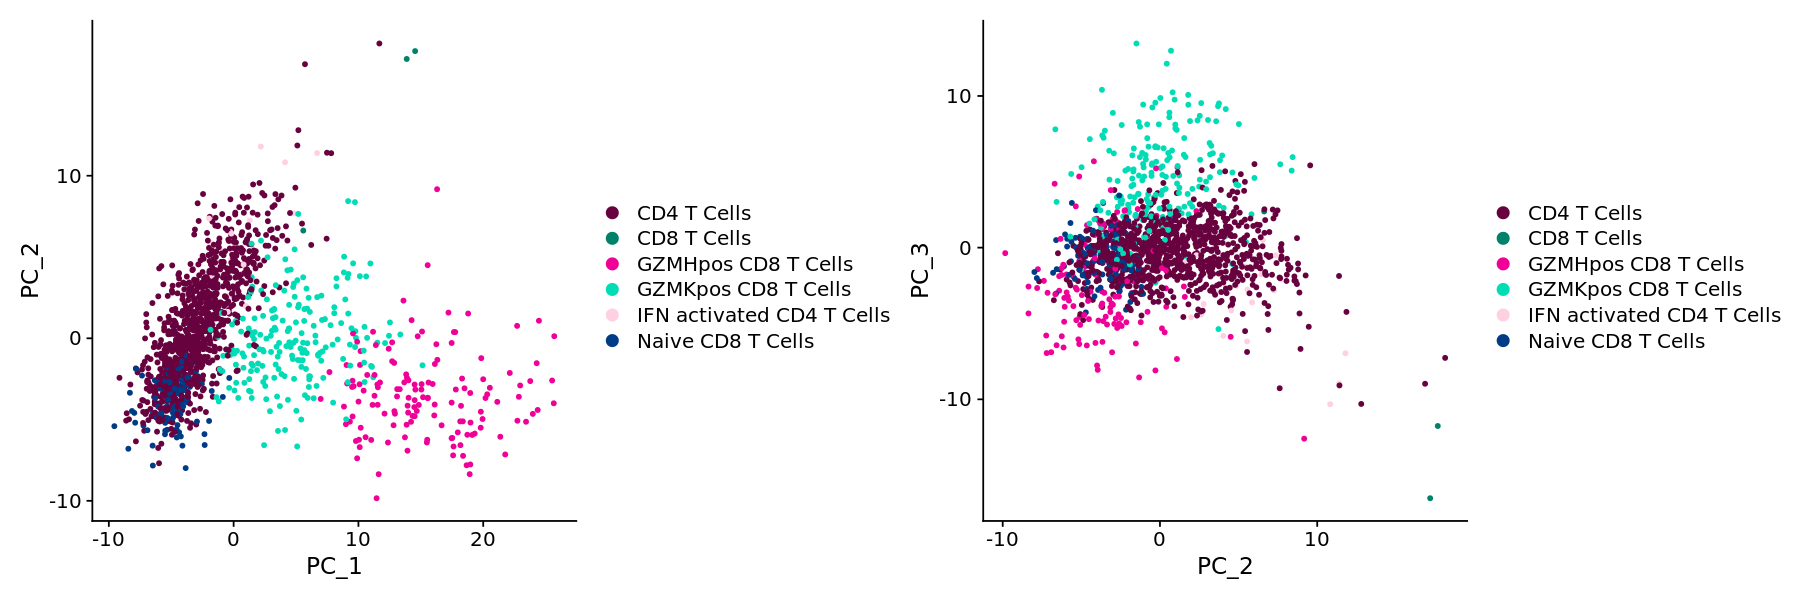

In [50]:
p2 <- DimPlot(pbmc.tcells, cols = cbpal18, reduction = 'pca')
p3 <- DimPlot(pbmc.tcells, cols = cbpal18, reduction = 'pca', dims = c(2,3))
p2 + p3

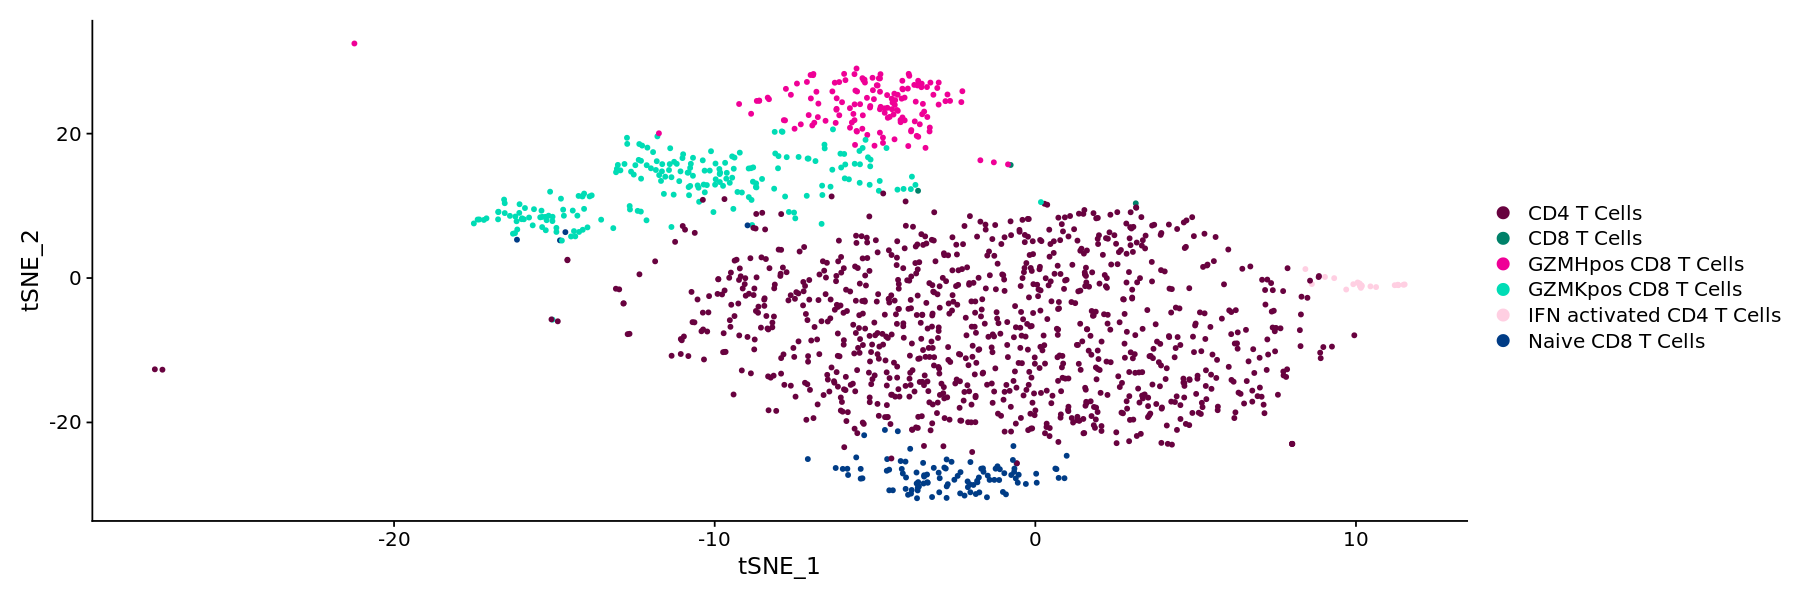

In [51]:
DimPlot(pbmc.tcells, cols = cbpal18, reduction = 'tsne')

You can also modify the ggplot in various ways.  Here are a few examples:

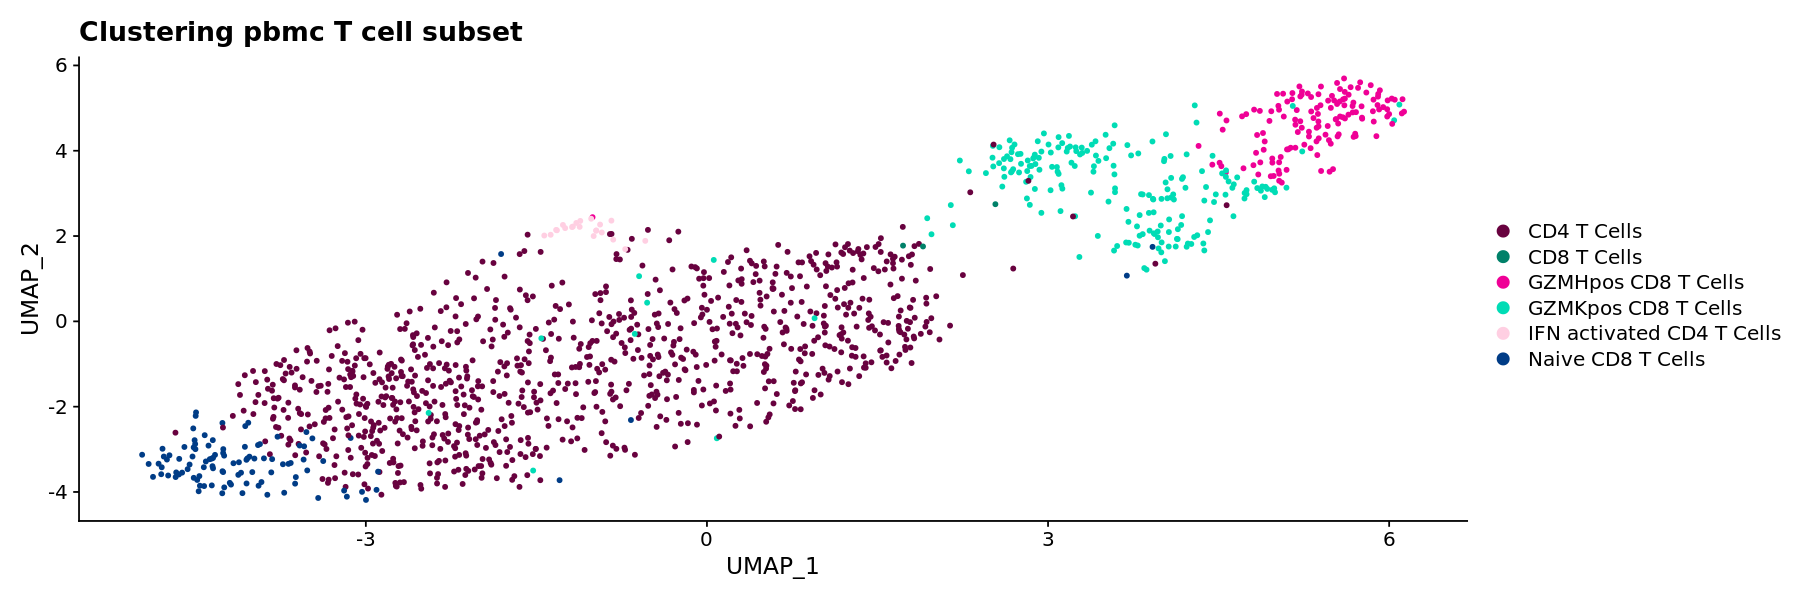

In [52]:
p1 + ggtitle("Clustering pbmc T cell subset")

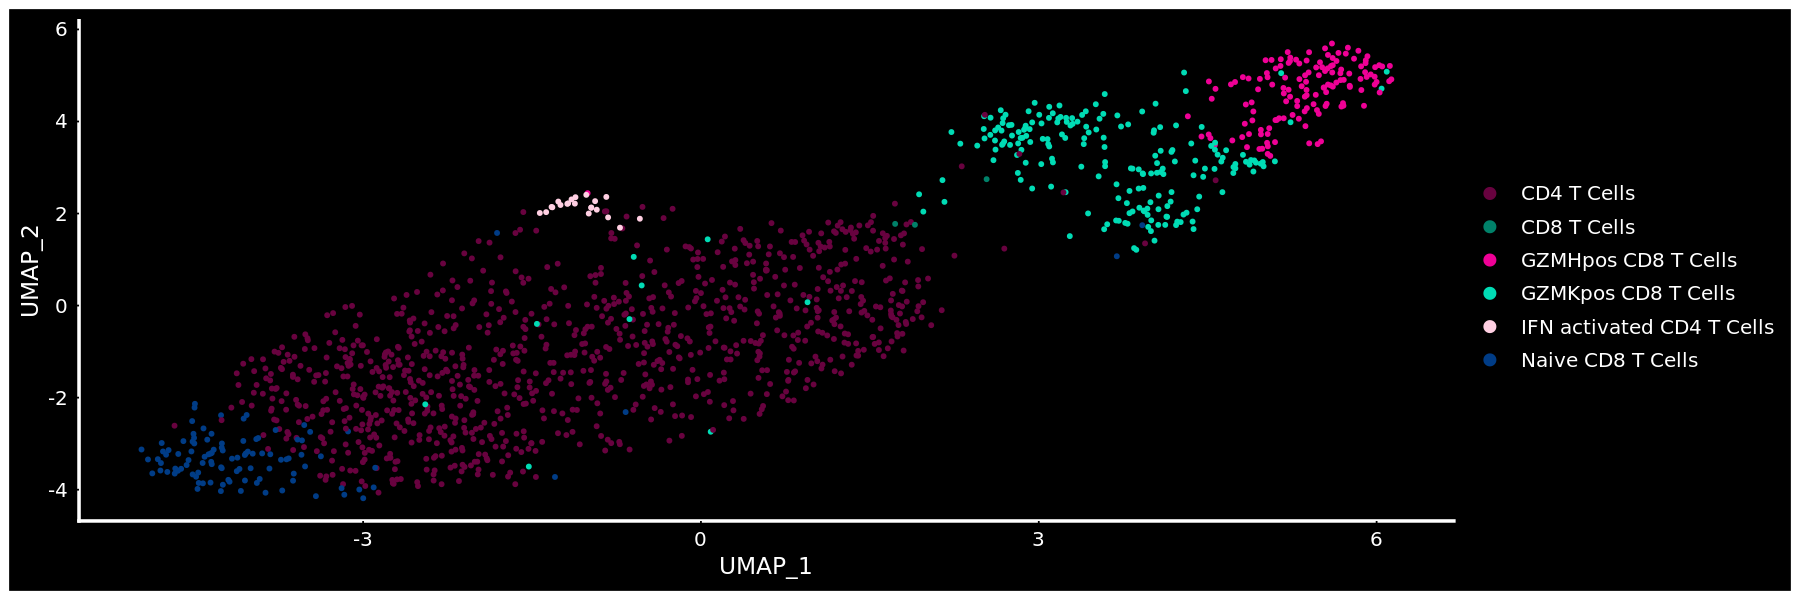

In [53]:
p1 + DarkTheme()

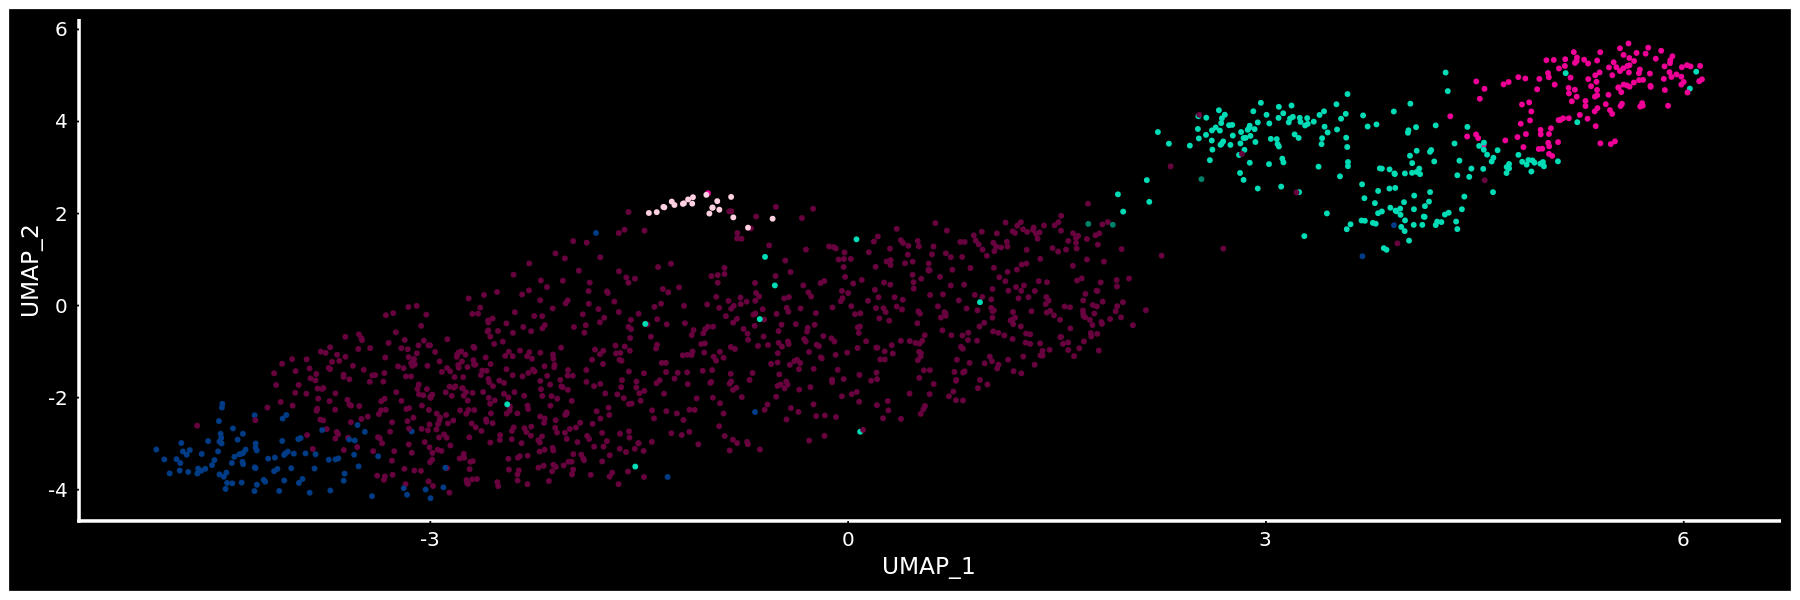

In [54]:
p1 + DarkTheme() + NoLegend()

If you'd like to save an .html file containing your jupyter notebook with all Rmarkdown documentation, code and results you can use the jupyter commmand nbconvert with your jupyter notebook name and file format to convert to; in this case, html.  Since we are running R and this is a bash command, this all needs to go inside the R base function `system()`.

In [55]:
system("jupyter nbconvert cluster_analysis_tutorial_seurat.ipynb --to html", intern=TRUE)

character(0)